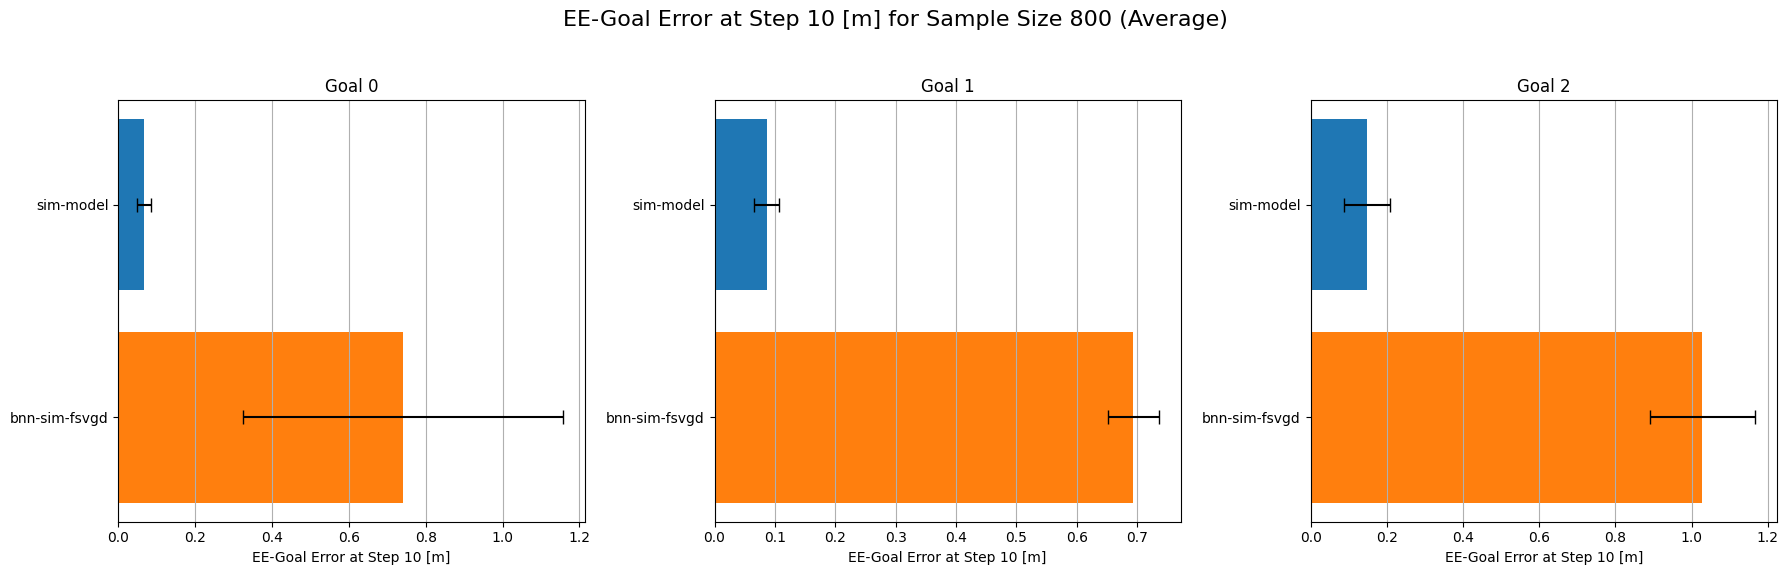

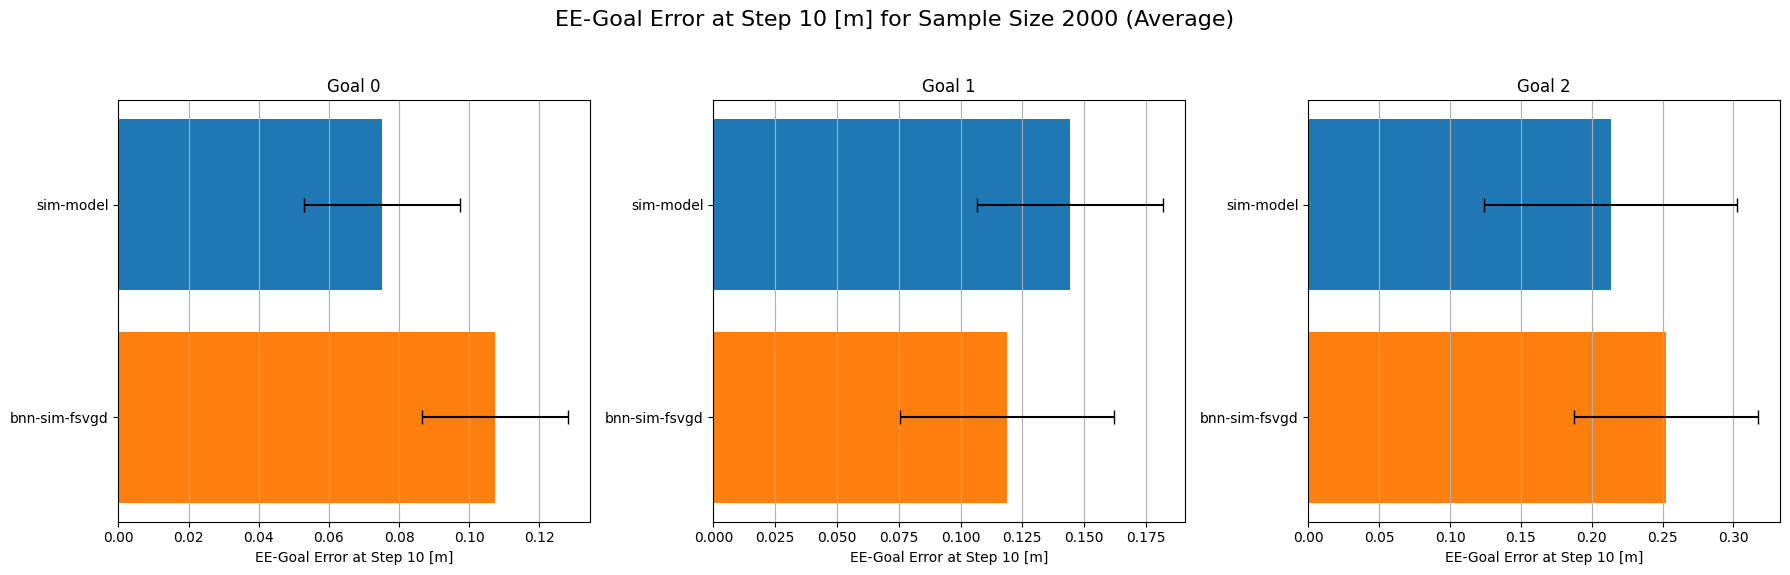

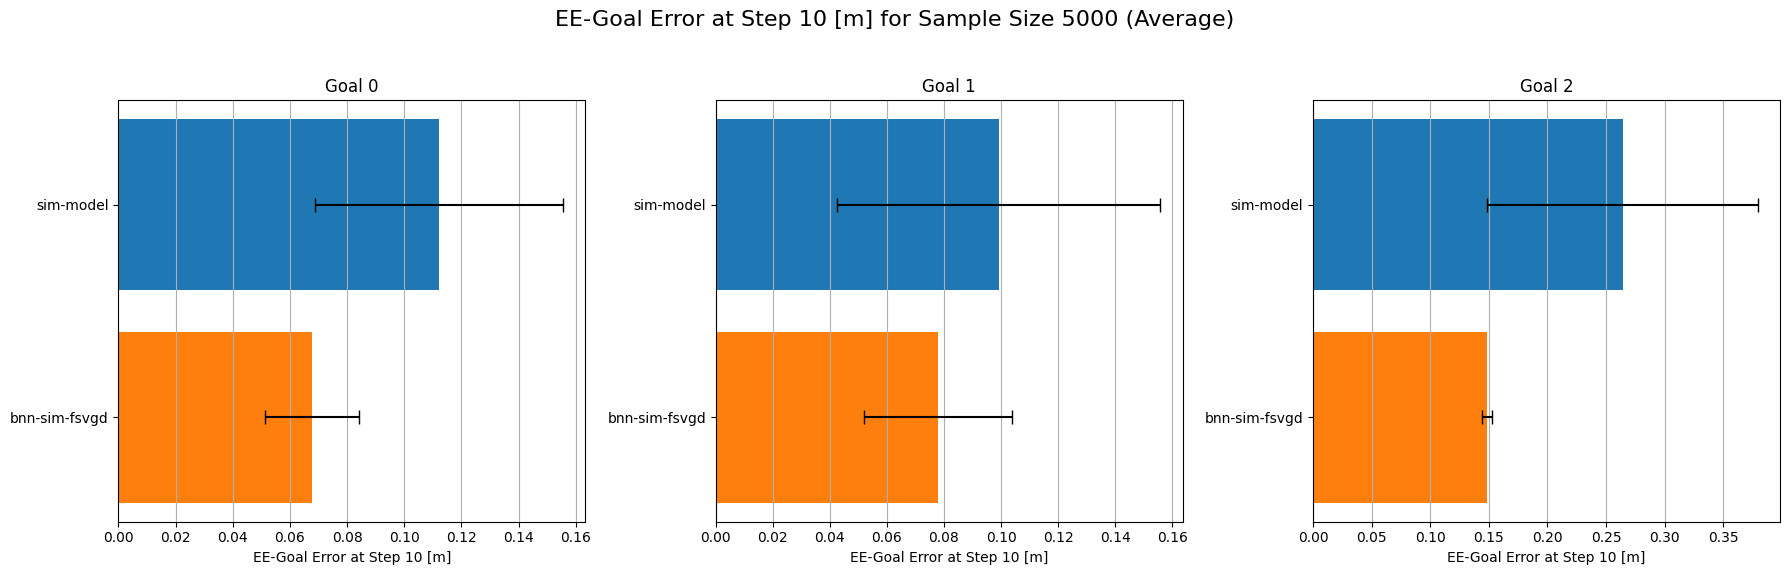

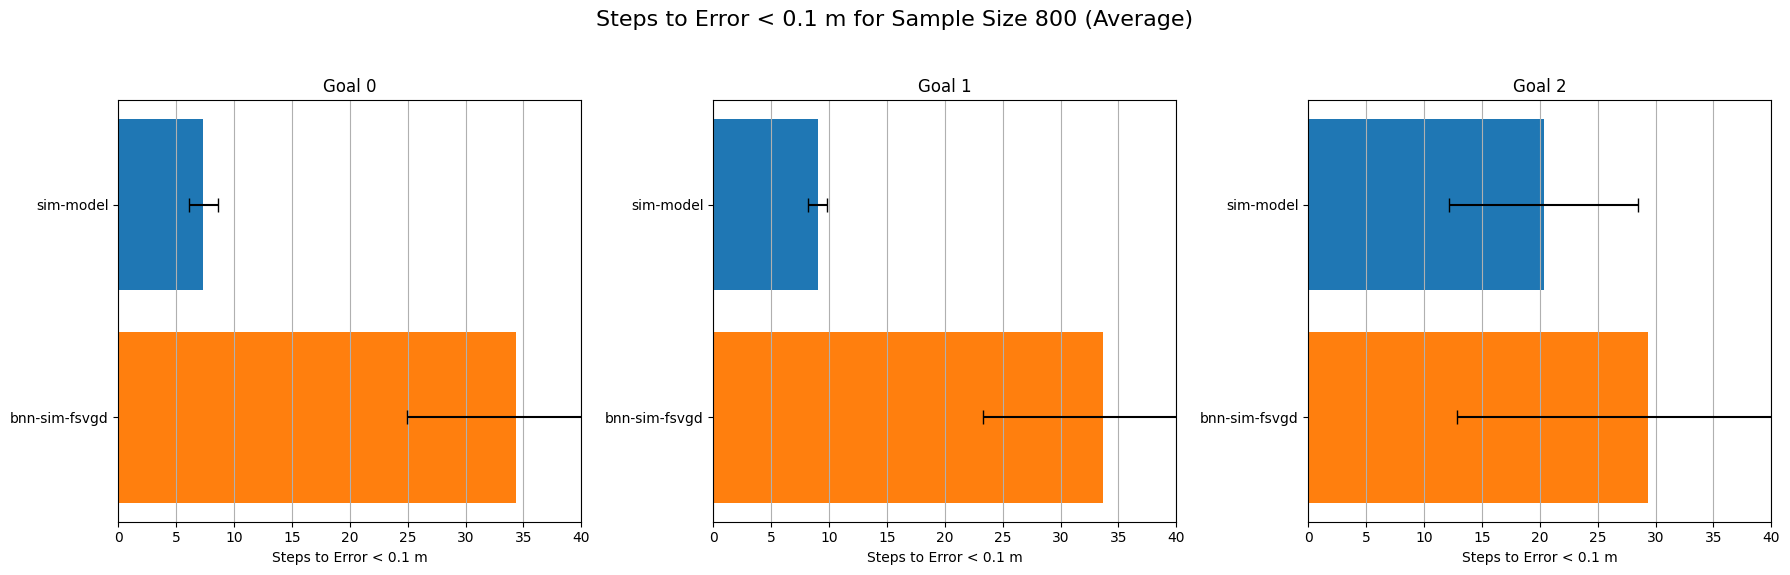

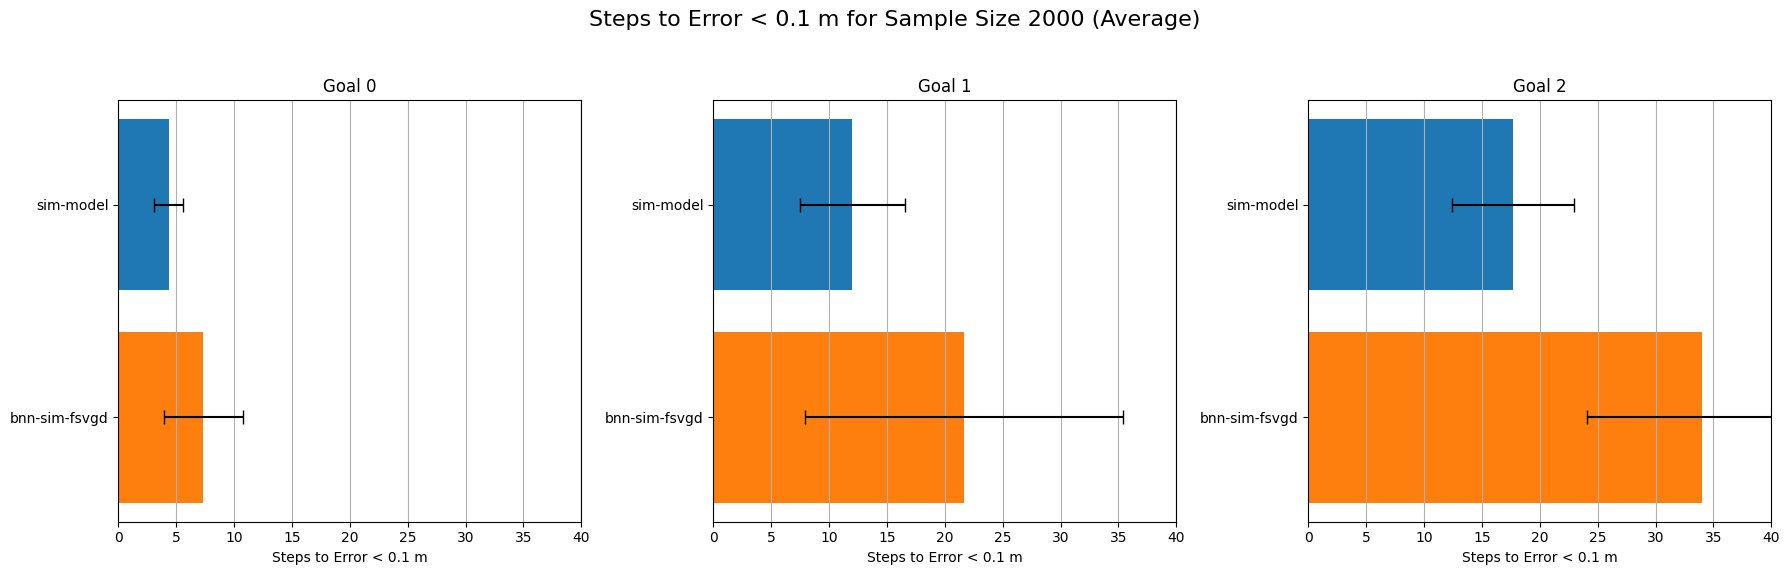

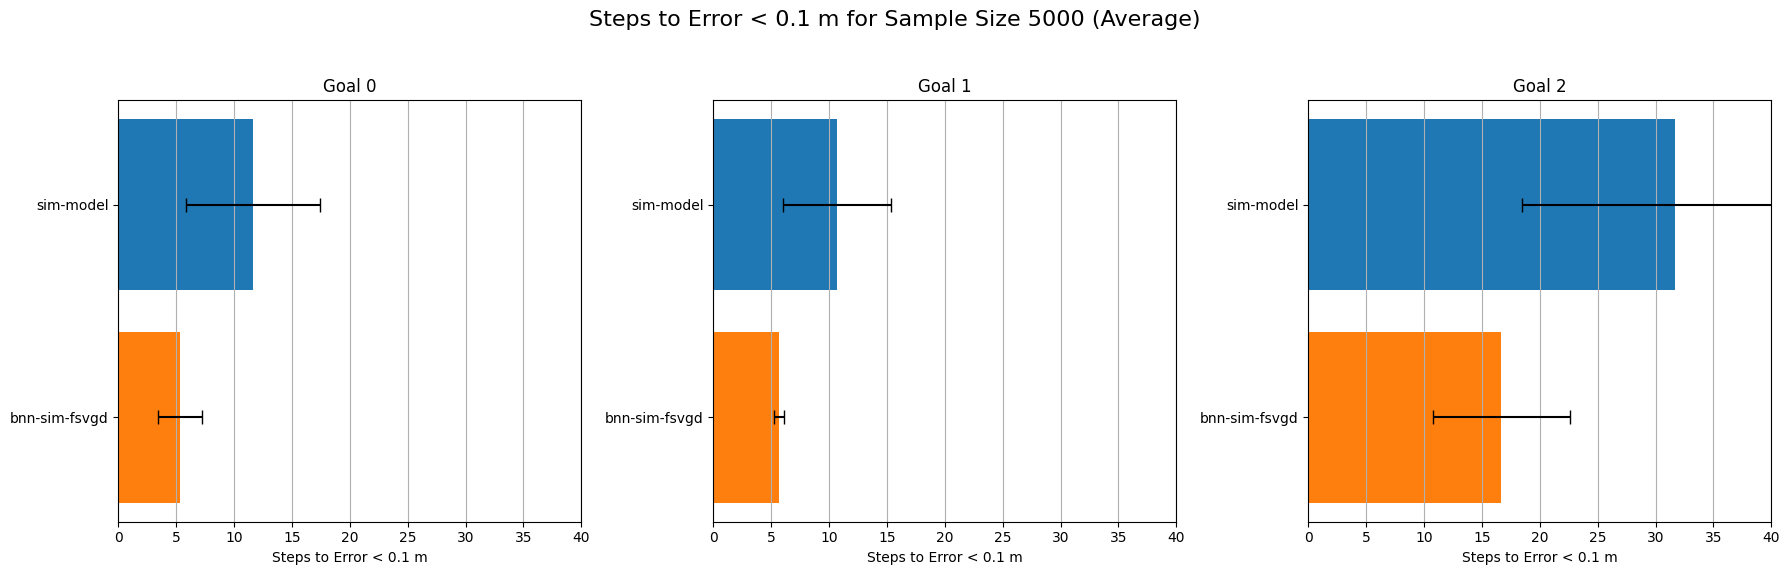

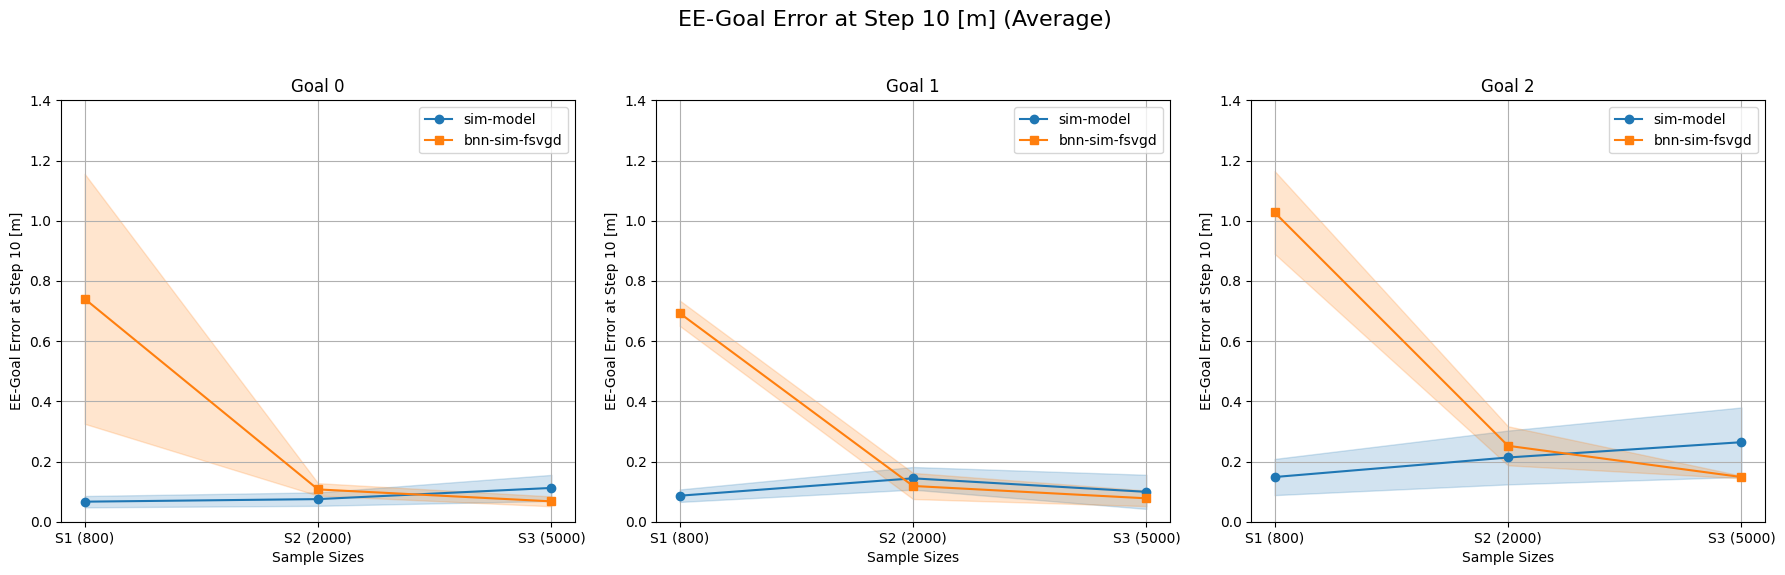

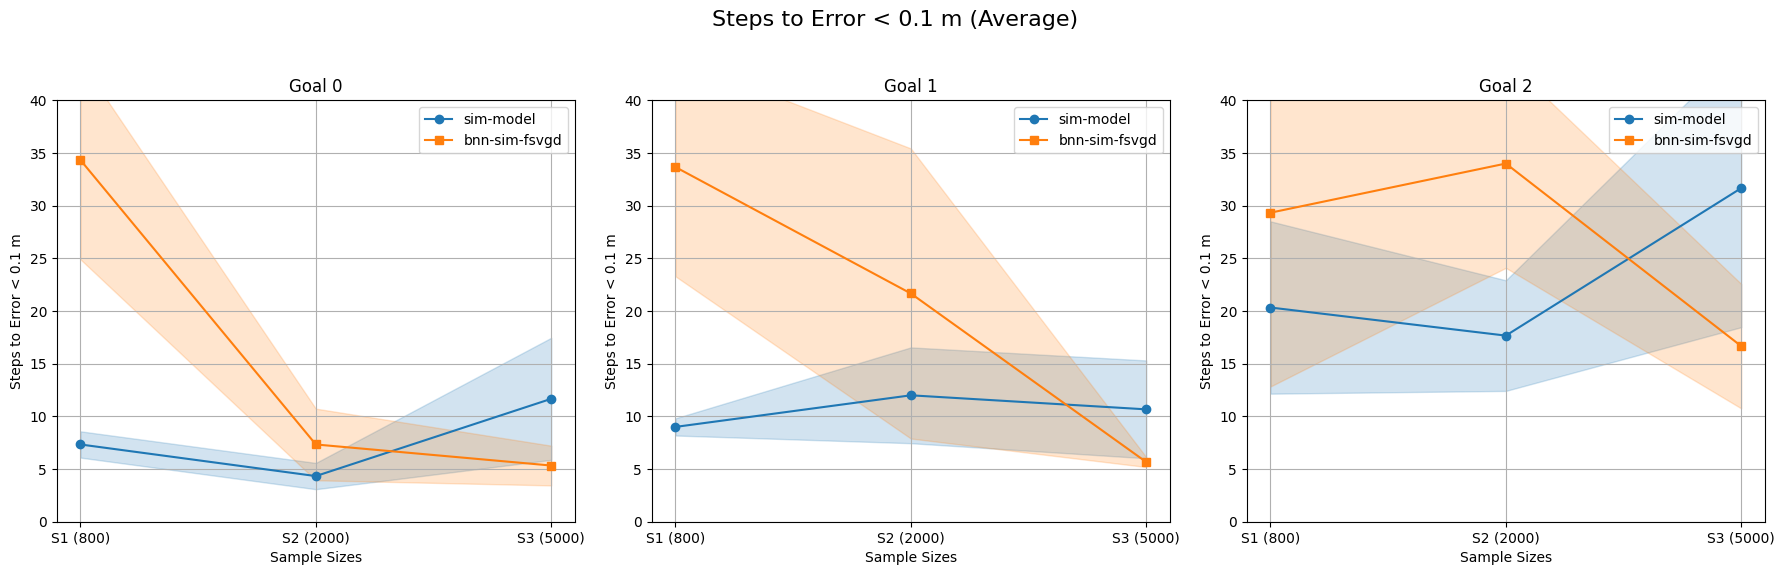

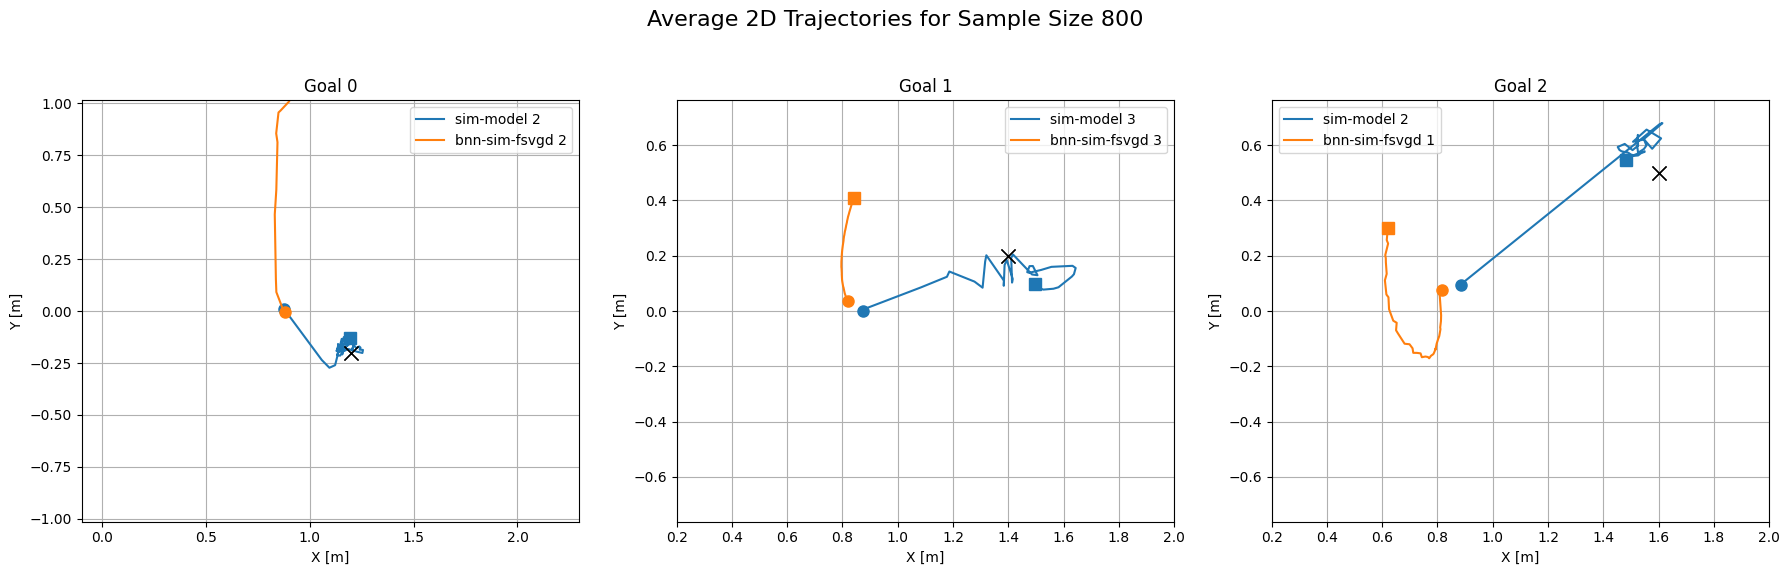

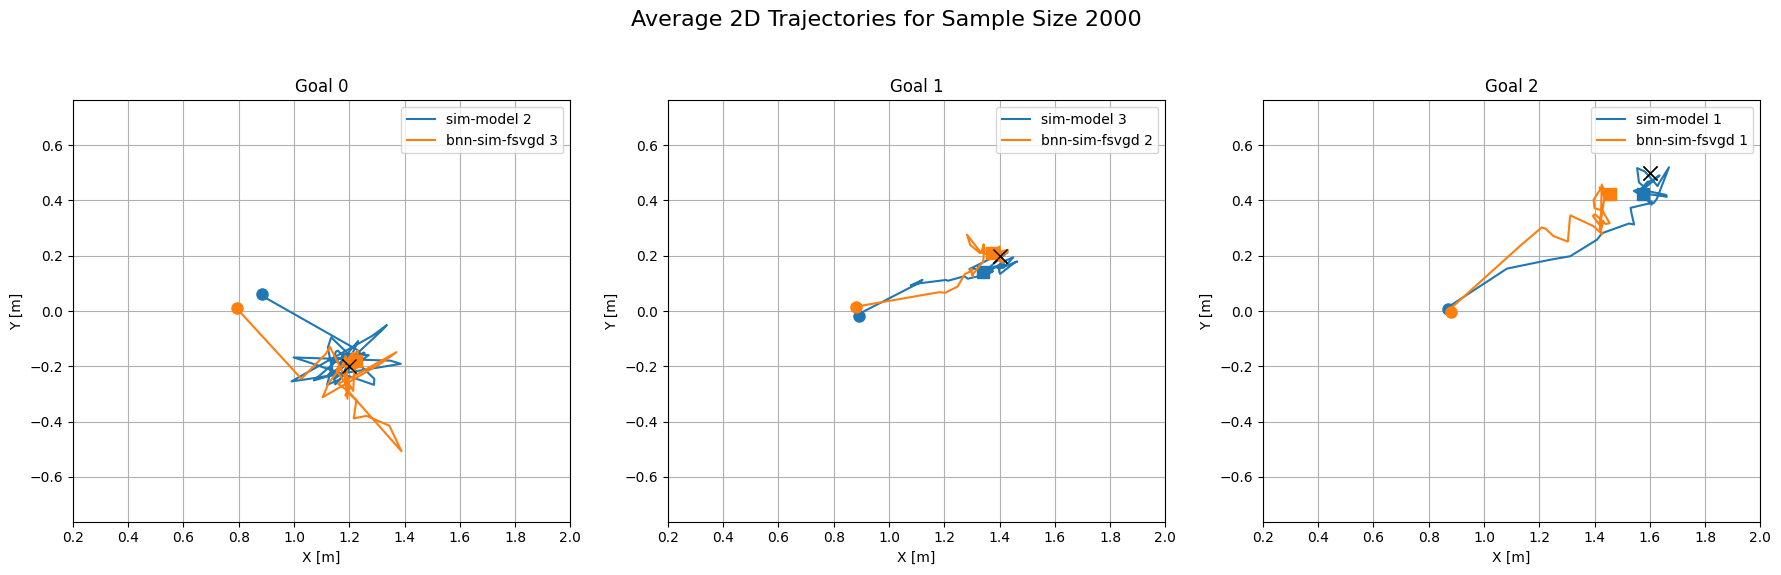

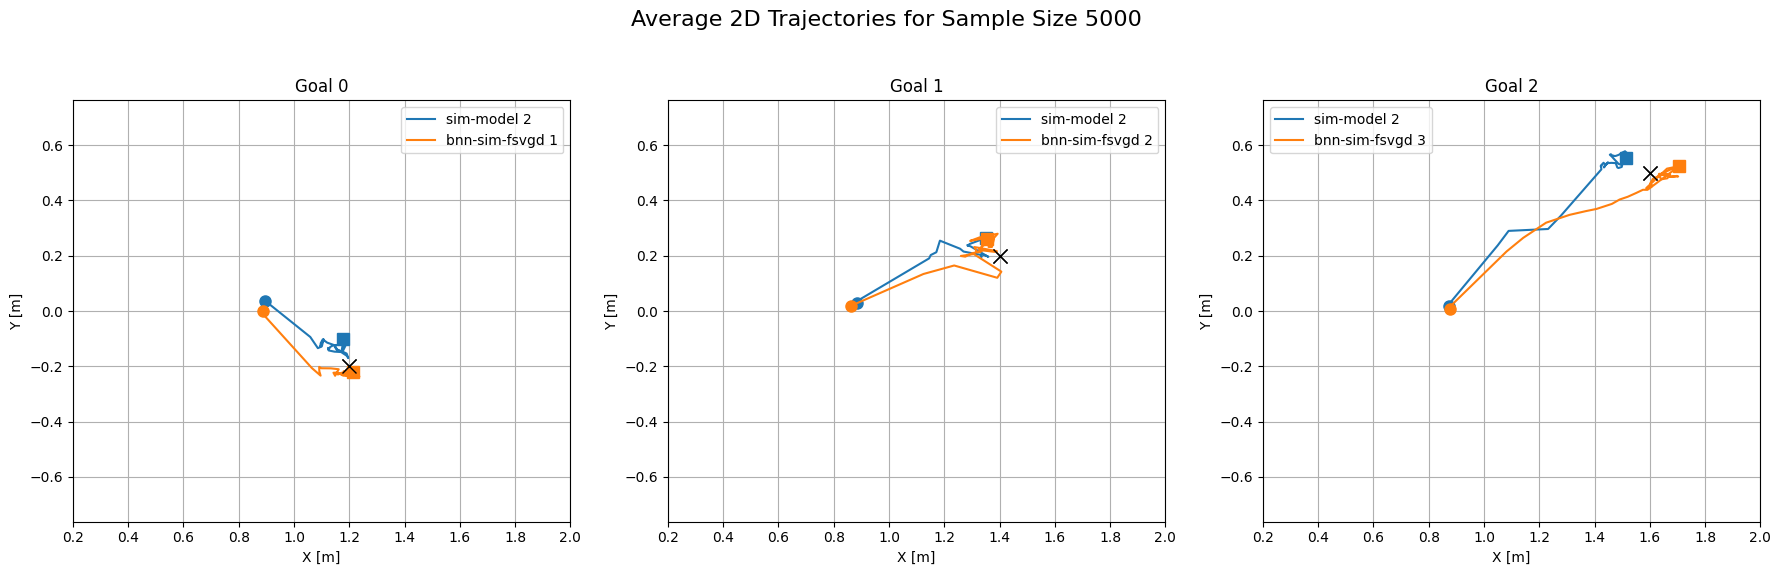

In [7]:
""" Full evaluation of policy performance on real robot """

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sim_transfer.sims.util import decode_angles
from brax.training.types import Transition
import jax.tree_util as jtu
import jax.numpy as jnp
import re
import os

# Use a style for better aesthetics
# plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use("seaborn-v0_8-colorblind")


# Global variables
step_index = 10  # Define the step index for error calculation
error_threshold = 0.1  # Threshold for EE-Goal error
plot_analysis = False  # Set to True to enable 'Analysis for Goal x' plots
steps_limits = (0, 40)

plot_variant = "average"  # Change this to 'best' or 'worst' as needed


# Define the list of trajectory files
file_paths = [
    # policy_testing_full_v9_new
    # bnn_sim_fsvgd
    # seed 1
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-122915_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123002_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123059_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123128_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123214_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123304_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123401_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123441_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123526_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_2__1.0/brax_transitions.pickle",
    # seed 2
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123652_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123736_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123812_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123851_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123942_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124028_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124113_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124157_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124301_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_2__1.0/brax_transitions.pickle",
    # seed 3
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124434_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124513_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124601_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124655_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124742_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124838_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124929_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125016_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125105_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_2__1.0/brax_transitions.pickle",
    # sim_model
    # seed 1
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125223_policy_testing_full_v9_7539krvw_sim-model_800_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125308_policy_testing_full_v9_7539krvw_sim-model_800_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125348_policy_testing_full_v9_7539krvw_sim-model_800_1_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125446_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125533_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125617_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125702_policy_testing_full_v9_pnqivxba_sim-model_5000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125747_policy_testing_full_v9_pnqivxba_sim-model_5000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125832_policy_testing_full_v9_pnqivxba_sim-model_5000_1_2__1.0/brax_transitions.pickle",
    # seed 2
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130234_policy_testing_full_v9_dwb45l5k_sim-model_800_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130315_policy_testing_full_v9_dwb45l5k_sim-model_800_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130359_policy_testing_full_v9_dwb45l5k_sim-model_800_2_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130445_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130534_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130616_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130704_policy_testing_full_v9_p50dxhru_sim-model_5000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130744_policy_testing_full_v9_p50dxhru_sim-model_5000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130828_policy_testing_full_v9_p50dxhru_sim-model_5000_2_2__1.0/brax_transitions.pickle",
    # seed 3
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131057_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131139_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131233_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131317_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131411_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131453_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131540_policy_testing_full_v9_fac8woya_sim-model_5000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131622_policy_testing_full_v9_fac8woya_sim-model_5000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131709_policy_testing_full_v9_fac8woya_sim-model_5000_3_2__1.0/brax_transitions.pickle",
]

# Define your goals
goal_1 = np.array([1.2, -0.2, 0.8])
goal_2 = np.array([1.4, 0.2, 0.4])
goal_3 = np.array([1.6, 0.5, 0.2])

goals = [goal_1, goal_2, goal_3]

# Initialize dictionaries to store data per goal and per model type
goal_data = {}
model_data = {}
data_per_model_sample_goal = {}  # Data per model, sample size, and goal


def extract_info_from_file_path(file_path):
    """Extract model info from file path."""
    dir_name = os.path.dirname(file_path)
    dir_base_name = os.path.basename(dir_name)
    parts = dir_base_name.split("_")

    # Find index of 8-character unique id
    for i in range(len(parts)):
        if re.match(r"^\w{8}$", parts[i]):
            uniqueid_parts = parts[: i + 1]
            uniqueid = "_".join(uniqueid_parts)
            rest_parts = parts[i + 1 :]
            break
    else:
        raise ValueError(f"Could not find unique id in file path {file_path}")

    if len(rest_parts) < 4:
        raise ValueError(f"Not enough parts in file path {file_path}")

    modeltype = rest_parts[0]
    samplesize = rest_parts[1]
    variant = rest_parts[2]
    goalindex = rest_parts[3]

    # Handle the double underscore
    params_and_rest = "_".join(rest_parts[4:])
    params_split = params_and_rest.split("__")
    if len(params_split) == 2:
        params = params_split[1]
    else:
        # Try splitting by '_'
        params_split = params_and_rest.split("_")
        if len(params_split) >= 1:
            params = params_split[-1]
        else:
            params = ""

    return {
        "uniqueid": uniqueid,
        "modeltype": modeltype,
        "samplesize": samplesize,
        "variant": variant,
        "goalindex": goalindex,
        "params": params,
    }


# Loop over each trajectory file
for idx, file_path in enumerate(file_paths):
    # Load trajectory from policy simulation
    with open(file_path, "rb") as file:
        traj_raw = pickle.load(file)

    # Extract info from file path
    info = extract_info_from_file_path(file_path)
    label = f"{info['modeltype']}_{info['samplesize']}_{info['variant']}_g{info['goalindex']}"
    model_type = info["modeltype"]
    sample_size = info["samplesize"]
    goal_index = int(info["goalindex"])
    variant = info["variant"]

    # Extract goal index
    if goal_index >= len(goals):
        raise ValueError(f"Goal index {goal_index} is out of bounds")

    goal = goals[goal_index]

    # Initialize data structures for this goal if not already done
    if goal_index not in goal_data:
        goal_data[goal_index] = {
            "file_paths": [],
            "labels": [],
            "observations": [],
            "actions": [],
            "rewards": [],
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
        }

    # Initialize data structures for this model type if not already done
    if model_type not in model_data:
        model_data[model_type] = {
            "labels": [],
            "observations": [],
            "actions": [],
            "rewards": [],
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
            "goals": [],
        }

    # Initialize data structures for data per model, sample size, and goal
    if model_type not in data_per_model_sample_goal:
        data_per_model_sample_goal[model_type] = {}
    if sample_size not in data_per_model_sample_goal[model_type]:
        data_per_model_sample_goal[model_type][sample_size] = {}
    if goal_index not in data_per_model_sample_goal[model_type][sample_size]:
        data_per_model_sample_goal[model_type][sample_size][goal_index] = {
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
            "labels": [],
            "observations": [],  # Store observations for trajectory plotting
            "variants": [],  # Store variants
        }

    # Add goal to observations
    def add_goal_to_obs(obs: jnp.ndarray, goal: jnp.ndarray) -> jnp.ndarray:
        return jnp.concatenate([obs, goal])

    new_traj = []

    # Add goal to each observation in the trajectory
    for i in range(len(traj_raw)):
        obs = traj_raw[i].observation
        next_obs = traj_raw[i].next_observation
        obs = add_goal_to_obs(obs, goal)
        next_obs = add_goal_to_obs(next_obs, goal)
        new_traj.append(
            Transition(
                observation=obs,
                action=traj_raw[i].action,
                reward=jnp.array(0),
                next_observation=next_obs,
                discount=traj_raw[i].discount,
            )
        )

    traj = jtu.tree_map(lambda *xs: jnp.stack(xs, axis=0), *new_traj)

    # Convert transitions to trajectory
    observations = traj.observation
    actions = traj.action
    rewards = traj.reward

    # Decode angles if needed
    if observations.shape[-1] == 16:
        observations = decode_angles(observations, 2)

    # Convert observations to numpy array
    observations_np = np.array(observations)

    # Calculate EE-Goal error over time
    ee_pos = observations_np[:, 6:9]
    goal_pos = observations_np[:, -3:]
    error = np.linalg.norm(ee_pos - goal_pos, axis=1)

    # EE-Goal error at step_index
    if len(error) > step_index:
        ee_goal_error_at_step = error[step_index]
    else:
        ee_goal_error_at_step = np.nan

    # Steps until error drops below threshold
    steps_below_threshold = np.where(error < error_threshold)[0]
    if steps_below_threshold.size > 0:
        steps_to_threshold = steps_below_threshold[0]
    else:
        # steps_to_threshold = np.nan  # Did not reach threshold
        steps_to_threshold = len(error)  # Set to max steps

    # Append data to the corresponding goal
    goal_data[goal_index]["file_paths"].append(file_path)
    goal_data[goal_index]["labels"].append(label)
    goal_data[goal_index]["observations"].append(observations_np)
    goal_data[goal_index]["actions"].append(np.array(actions))
    goal_data[goal_index]["rewards"].append(np.array(rewards))
    goal_data[goal_index]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    goal_data[goal_index]["steps_below_threshold"].append(steps_to_threshold)

    # Append data to the corresponding model type
    model_data[model_type]["labels"].append(f"{label}")
    model_data[model_type]["observations"].append(observations_np)
    model_data[model_type]["actions"].append(np.array(actions))
    model_data[model_type]["rewards"].append(np.array(rewards))
    model_data[model_type]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    model_data[model_type]["steps_below_threshold"].append(steps_to_threshold)
    model_data[model_type]["goals"].append(goal_index)

    # Append data to data_per_model_sample_goal
    data_per_model_sample_goal[model_type][sample_size][goal_index][
        "ee_goal_errors_at_step"
    ].append(ee_goal_error_at_step)
    data_per_model_sample_goal[model_type][sample_size][goal_index][
        "steps_below_threshold"
    ].append(steps_to_threshold)
    data_per_model_sample_goal[model_type][sample_size][goal_index]["labels"].append(
        label
    )
    data_per_model_sample_goal[model_type][sample_size][goal_index][
        "observations"
    ].append(
        observations_np
    )  # Store observations
    data_per_model_sample_goal[model_type][sample_size][goal_index]["variants"].append(
        variant
    )

# Ensure the model types are in the specified order
# model_types = ["sim-model", "bnn-fsvgd", "bnn-sim-fsvgd"]
model_types = ["sim-model", "bnn-sim-fsvgd"]


# Extract sample sizes
sample_sizes = set()
for model_type in data_per_model_sample_goal:
    for sample_size in data_per_model_sample_goal[model_type]:
        sample_sizes.add(sample_size)

sample_sizes = sorted(sample_sizes, key=lambda x: int(x))  # Sort numerically

# Define colors for consistency
colors = plt.get_cmap("tab10").colors
color_dict = dict(zip(model_types, colors))


# Function to compute statistics based on plot_variant
def compute_statistics(data_per_model_sample_goal, plot_variant):
    """Compute statistics based on the selected plot_variant."""
    stats_ee_goal_error_at_step = {}
    stats_steps_below_threshold = {}
    selected_trajectories = {}

    for model_type in data_per_model_sample_goal:
        stats_ee_goal_error_at_step[model_type] = {}
        stats_steps_below_threshold[model_type] = {}
        selected_trajectories[model_type] = {}
        for sample_size in data_per_model_sample_goal[model_type]:
            stats_ee_goal_error_at_step[model_type][sample_size] = {}
            stats_steps_below_threshold[model_type][sample_size] = {}
            selected_trajectories[model_type][sample_size] = {}
            for goal_index in data_per_model_sample_goal[model_type][sample_size]:
                errors = data_per_model_sample_goal[model_type][sample_size][
                    goal_index
                ]["ee_goal_errors_at_step"]
                steps = data_per_model_sample_goal[model_type][sample_size][goal_index][
                    "steps_below_threshold"
                ]
                labels = data_per_model_sample_goal[model_type][sample_size][
                    goal_index
                ]["labels"]
                observations_list = data_per_model_sample_goal[model_type][sample_size][
                    goal_index
                ]["observations"]
                variants = data_per_model_sample_goal[model_type][sample_size][
                    goal_index
                ]["variants"]

                # Remove NaN values before computing statistics
                valid_indices = [
                    i
                    for i in range(len(errors))
                    if not np.isnan(errors[i]) or not np.isnan(steps[i])
                ]

                # Compute average and std
                errors_clean = [
                    errors[i] for i in valid_indices if not np.isnan(errors[i])
                ]
                steps_clean = [
                    steps[i] for i in valid_indices if not np.isnan(steps[i])
                ]

                if errors_clean:
                    avg_error = np.mean(errors_clean)
                    std_error = np.std(errors_clean)
                else:
                    avg_error = std_error = np.nan

                if steps_clean:
                    avg_step = np.mean(steps_clean)
                    std_step = np.std(steps_clean)
                else:
                    avg_step = std_step = np.nan

                stats_ee_goal_error_at_step[model_type][sample_size][goal_index] = (
                    avg_error,
                    std_error,
                )
                stats_steps_below_threshold[model_type][sample_size][goal_index] = (
                    avg_step,
                    std_step,
                )

                # Select trajectory for plotting
                if valid_indices:
                    # Prepare lists for available errors and steps
                    error_indices = [
                        i for i in valid_indices if not np.isnan(errors[i])
                    ]
                    error_values_array = np.array([errors[i] for i in error_indices])
                    error_ranks = error_values_array.argsort().argsort()
                    error_ranks_dict = dict(zip(error_indices, error_ranks))

                    step_indices = [i for i in valid_indices if not np.isnan(steps[i])]
                    step_values_array = np.array([steps[i] for i in step_indices])
                    step_ranks = step_values_array.argsort().argsort()
                    step_ranks_dict = dict(zip(step_indices, step_ranks))

                    # Compute total ranks
                    total_ranks = {}
                    for idx in valid_indices:
                        ranks = 0
                        if idx in error_ranks_dict and idx in step_ranks_dict:
                            # Both indicators available
                            ranks = error_ranks_dict[idx] + step_ranks_dict[idx]
                        elif idx in error_ranks_dict:
                            # Only error available
                            ranks = 2 * error_ranks_dict[idx]
                        elif idx in step_ranks_dict:
                            # Only step available
                            ranks = 2 * step_ranks_dict[idx]
                        else:
                            continue  # Should not happen
                        total_ranks[idx] = ranks

                    if plot_variant == "best":
                        selected_idx = min(total_ranks, key=total_ranks.get)
                    elif plot_variant == "worst":
                        selected_idx = max(total_ranks, key=total_ranks.get)
                    elif plot_variant == "average":
                        # Select median rank
                        sorted_total_ranks = sorted(
                            total_ranks.items(), key=lambda x: x[1]
                        )
                        median_idx = len(sorted_total_ranks) // 2
                        selected_idx = sorted_total_ranks[median_idx][0]

                    selected_error = errors[selected_idx]
                    selected_step = steps[selected_idx]
                    selected_label = labels[selected_idx]
                    selected_observation = observations_list[selected_idx]
                    selected_variant = variants[selected_idx]

                    selected_trajectories[model_type][sample_size][goal_index] = {
                        "label": selected_label,
                        "observations": selected_observation,
                        "variant": selected_variant,
                    }

                else:
                    # No valid data
                    selected_trajectories[model_type][sample_size][goal_index] = None

    return (
        stats_ee_goal_error_at_step,
        stats_steps_below_threshold,
        selected_trajectories,
    )


# Compute statistics based on the selected plot_variant
stats_ee_goal_error_at_step, stats_steps_below_threshold, selected_trajectories = (
    compute_statistics(data_per_model_sample_goal, plot_variant)
)

# Plotting functions


def plot_per_sample_size_horizontal_bar(
    stats_data, sample_sizes, model_types, metric_name, x_limits=None
):
    """Plot horizontal bar charts per sample size per goal."""
    for sample_size in sample_sizes:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        for goal_index in range(3):  # Assuming goals are 0,1,2
            ax = axs[goal_index]
            avg_values = []
            std_values = []
            labels = []
            colors = []
            for idx, model_type in enumerate(model_types):
                if sample_size in stats_data.get(model_type, {}):
                    if goal_index in stats_data[model_type][sample_size]:
                        avg_value, std_value = stats_data[model_type][sample_size][
                            goal_index
                        ]
                        avg_values.append(avg_value)
                        std_values.append(std_value)
                        labels.append(model_type)
                        colors.append(color_dict[model_type])
            y_positions = np.arange(len(labels))
            # Convert lists to NumPy arrays
            avg_values = np.array(avg_values)
            std_values = np.array(std_values)
            if plot_variant == "average":
                # Plot bars with error bars representing std
                ax.barh(
                    y_positions,
                    avg_values,
                    xerr=std_values,
                    align="center",
                    color=colors,
                    ecolor="black",
                    capsize=5,
                )
            else:
                # Plot bars without error bars
                ax.barh(y_positions, avg_values, align="center", color=colors)
            ax.set_yticks(y_positions)
            ax.set_yticklabels(labels)
            ax.set_xlabel(metric_name)
            ax.set_title(f"Goal {goal_index}")
            ax.invert_yaxis()
            ax.grid(True, axis="x")
            if x_limits is not None:
                ax.set_xlim(x_limits)
        plt.suptitle(
            f"{metric_name} for Sample Size {sample_size} ({plot_variant.capitalize()})",
            fontsize=16,
        )
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


def plot_metric_vs_sample_size_line(
    stats_data, sample_sizes, model_types, metric_name, y_limits=None
):
    """Plot line charts per plot type with one subplot per goal."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for goal_index in range(3):  # Assuming goals are 0,1,2
        ax = axs[goal_index]
        markers = ["o", "s", "D"]  # Different markers for model types
        for idx, model_type in enumerate(model_types):
            avg_values = []
            std_values = []
            sample_size_labels = []
            for sample_size in sample_sizes:
                sample_size_labels.append(
                    f"S{sample_sizes.index(sample_size)+1} ({sample_size})"
                )
                if sample_size in stats_data.get(model_type, {}):
                    if goal_index in stats_data[model_type][sample_size]:
                        avg_value, std_value = stats_data[model_type][sample_size][
                            goal_index
                        ]
                        avg_values.append(avg_value)
                        std_values.append(std_value)
                    else:
                        avg_values.append(np.nan)
                        std_values.append(0)
                else:
                    avg_values.append(np.nan)
                    std_values.append(0)
            # Convert lists to NumPy arrays
            avg_values = np.array(avg_values)
            std_values = np.array(std_values)
            # Create x positions
            x_positions = np.arange(len(sample_sizes))
            # Plot line
            if plot_variant == "average":
                # Plot with shaded area
                ax.plot(
                    x_positions,
                    avg_values,
                    label=f"{model_type}",
                    color=color_dict[model_type],
                    marker=markers[idx],
                )
                ax.fill_between(
                    x_positions,
                    avg_values - std_values,
                    avg_values + std_values,
                    color=color_dict[model_type],
                    alpha=0.2,
                )
            else:
                # Plot without error bars
                ax.plot(
                    x_positions,
                    avg_values,
                    label=f"{model_type}",
                    color=color_dict[model_type],
                    marker=markers[idx],
                )
        # Set x-axis labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels([f"S{sample_sizes.index(s)+1} ({s})" for s in sample_sizes])
        ax.set_xlabel("Sample Sizes")
        ax.set_ylabel(metric_name)
        ax.set_title(f"Goal {goal_index}")
        ax.legend(loc="upper right")
        ax.grid(True)
        if y_limits is not None:
            ax.set_ylim(y_limits)
    plt.suptitle(f"{metric_name} ({plot_variant.capitalize()})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_best_2d_trajectories(selected_trajectories, x_limits, y_limits):
    """Plot the best/worst 2D trajectories per sample size and goal."""
    for sample_size in sample_sizes:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        for goal_index in range(3):
            ax = axs[goal_index]
            for model_type in model_types:
                traj_info = selected_trajectories[model_type][sample_size].get(
                    goal_index
                )
                if traj_info and traj_info["observations"] is not None:
                    obs = traj_info["observations"]
                    label = traj_info["label"]
                    # Extract variant from label
                    variant = traj_info["variant"]
                    label_with_variant = f"{model_type} {variant}"
                    color = color_dict[model_type]
                    # Plot EE trajectory
                    ax.plot(obs[:, 6], obs[:, 7], label=label_with_variant, color=color)
                    # Plot EE start and end points
                    ax.plot(obs[0, 6], obs[0, 7], "o", color=color, markersize=8)
                    ax.plot(obs[-1, 6], obs[-1, 7], "s", color=color, markersize=8)
                    # Plot goal position
                    ax.plot(obs[0, -3], obs[0, -2], "x", color="black", markersize=10)
            ax.set_title(f"Goal {goal_index}")
            ax.set_xlabel("X [m]")
            ax.set_ylabel("Y [m]")
            ax.axis("equal")
            ax.set_xlim(x_limits)
            ax.set_ylim(y_limits)
            ax.legend()
            ax.grid(True)
        plt.suptitle(
            f"{plot_variant.capitalize()} 2D Trajectories for Sample Size {sample_size}",
            fontsize=16,
        )
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


# Plotting per your specifications

# 1. Per sample size, horizontal bar charts with subplots per goal

# Plot EE-Goal Error at Step 10
plot_per_sample_size_horizontal_bar(
    stats_ee_goal_error_at_step,
    sample_sizes,
    model_types,
    f"EE-Goal Error at Step {step_index} [m]",
)

# Plot Steps to Error < threshold
plot_per_sample_size_horizontal_bar(
    stats_steps_below_threshold,
    sample_sizes,
    model_types,
    f"Steps to Error < {error_threshold} m",
    x_limits=steps_limits,
)

# 2. Line plots grouped into one figure per plot type with subplots per goal, legend in top right

# Plot EE-Goal Error at Step 10 vs. Sample Sizes
plot_metric_vs_sample_size_line(
    stats_ee_goal_error_at_step,
    sample_sizes,
    model_types,
    f"EE-Goal Error at Step {step_index} [m]",
    y_limits=(0.0, 1.4),
)

# Plot Steps to Error < threshold vs. Sample Sizes
plot_metric_vs_sample_size_line(
    stats_steps_below_threshold,
    sample_sizes,
    model_types,
    f"Steps to Error < {error_threshold} m",
    y_limits=steps_limits,
)

# 3. Plot best/worst 2D trajectories per sample size and goal if plot_variant is 'best' or 'worst'

if plot_variant in ["best", "worst", "average"]:
    # Define x and y limits for the plots
    x_limits = (0.2, 2.0)
    y_limits = (-1.5, 1.5)
    # Plot best/worst 2D trajectories
    plot_best_2d_trajectories(selected_trajectories, x_limits, y_limits)

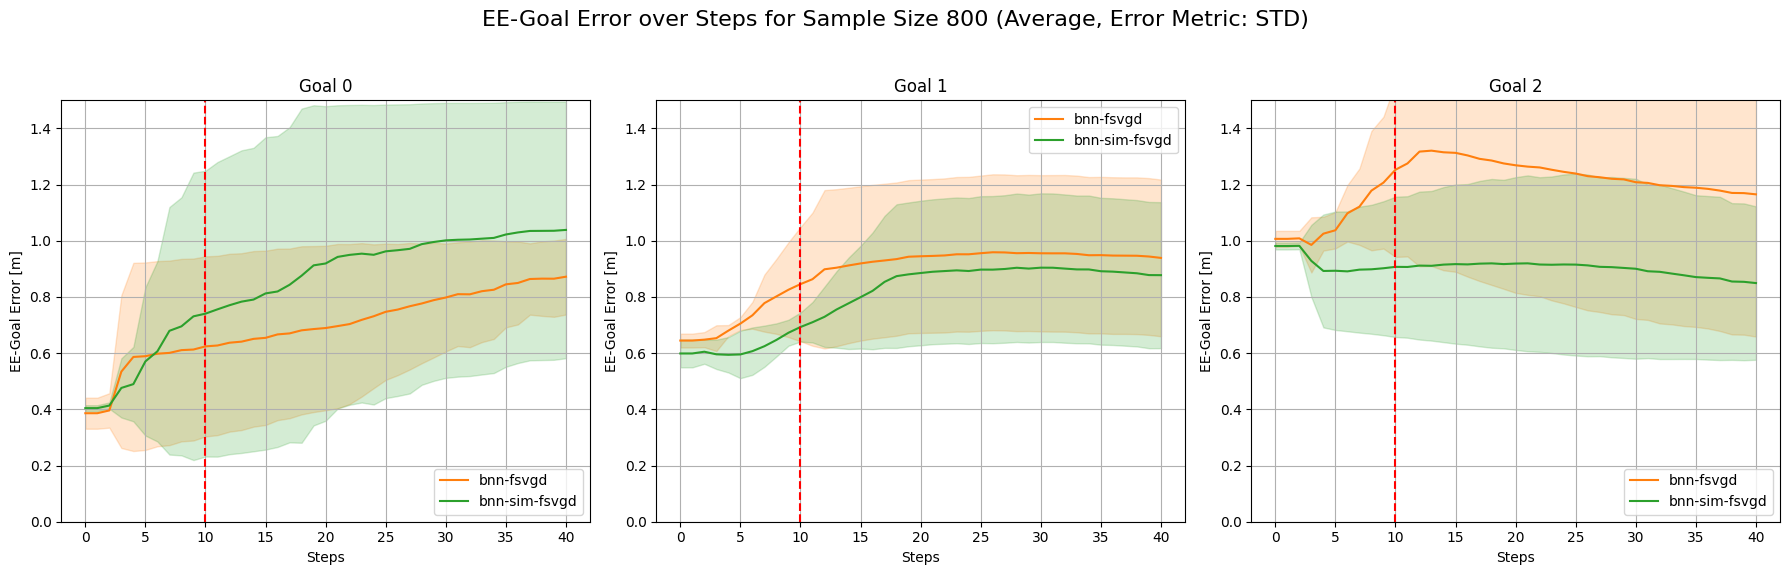

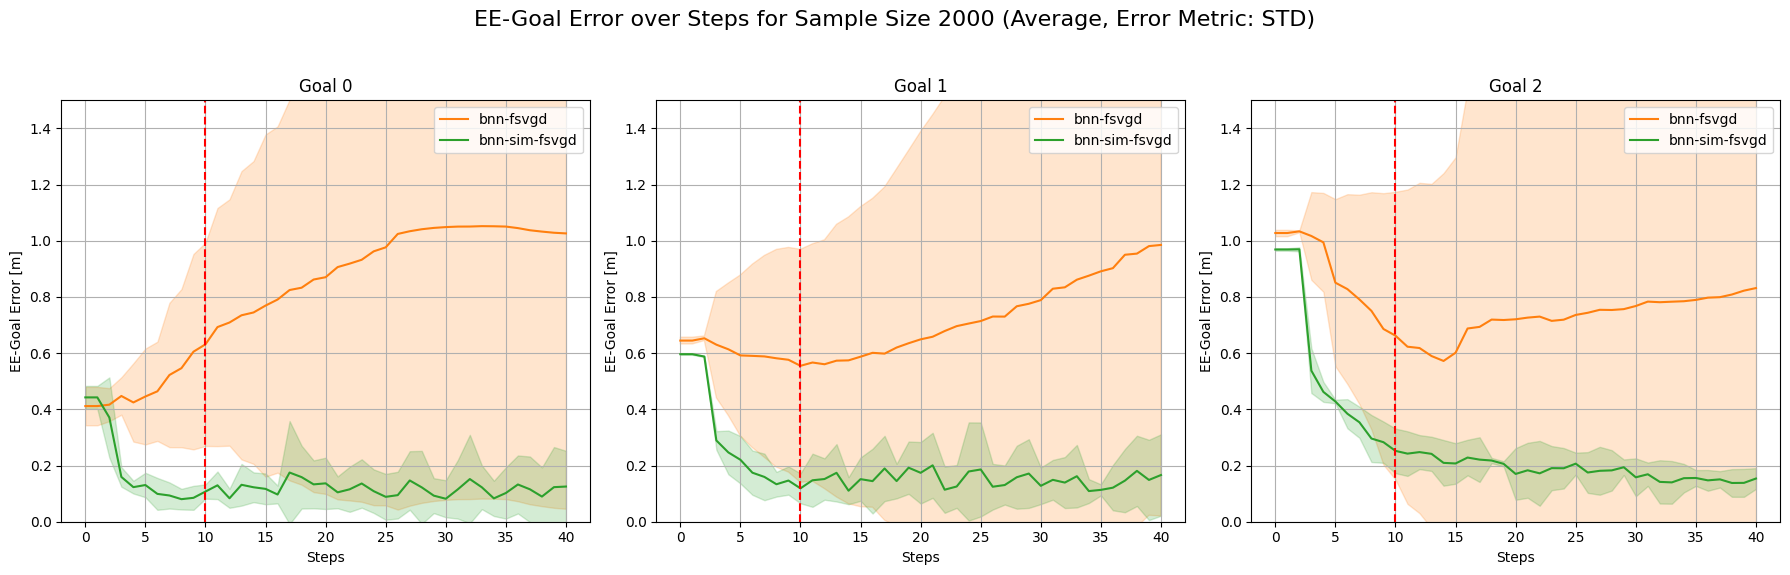

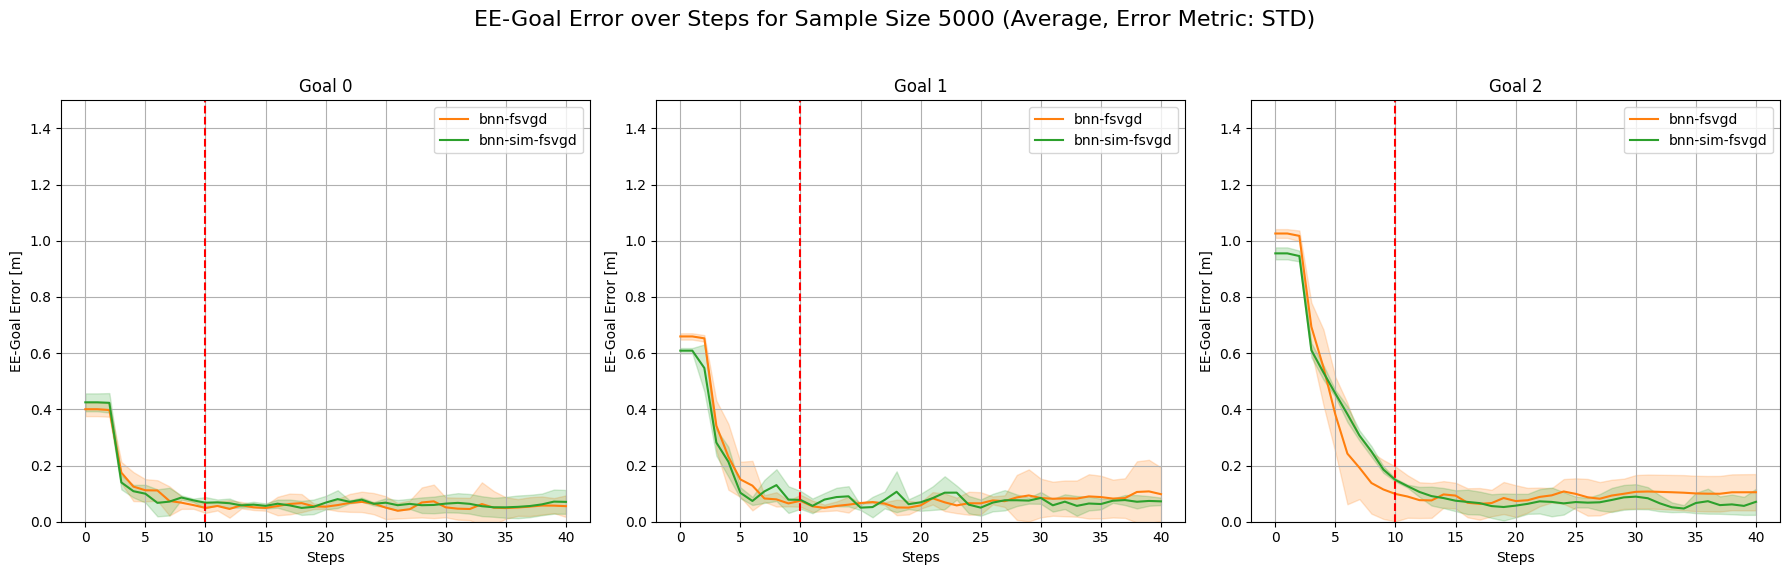

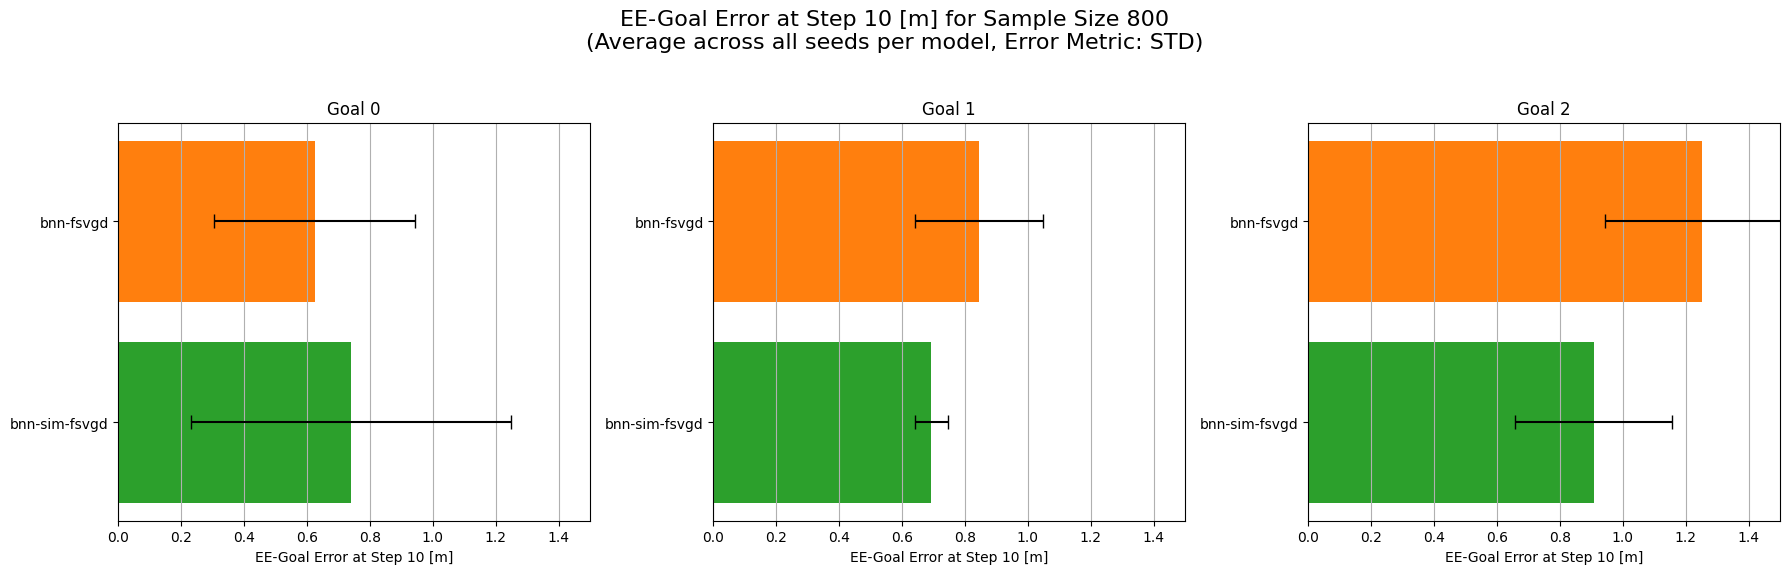

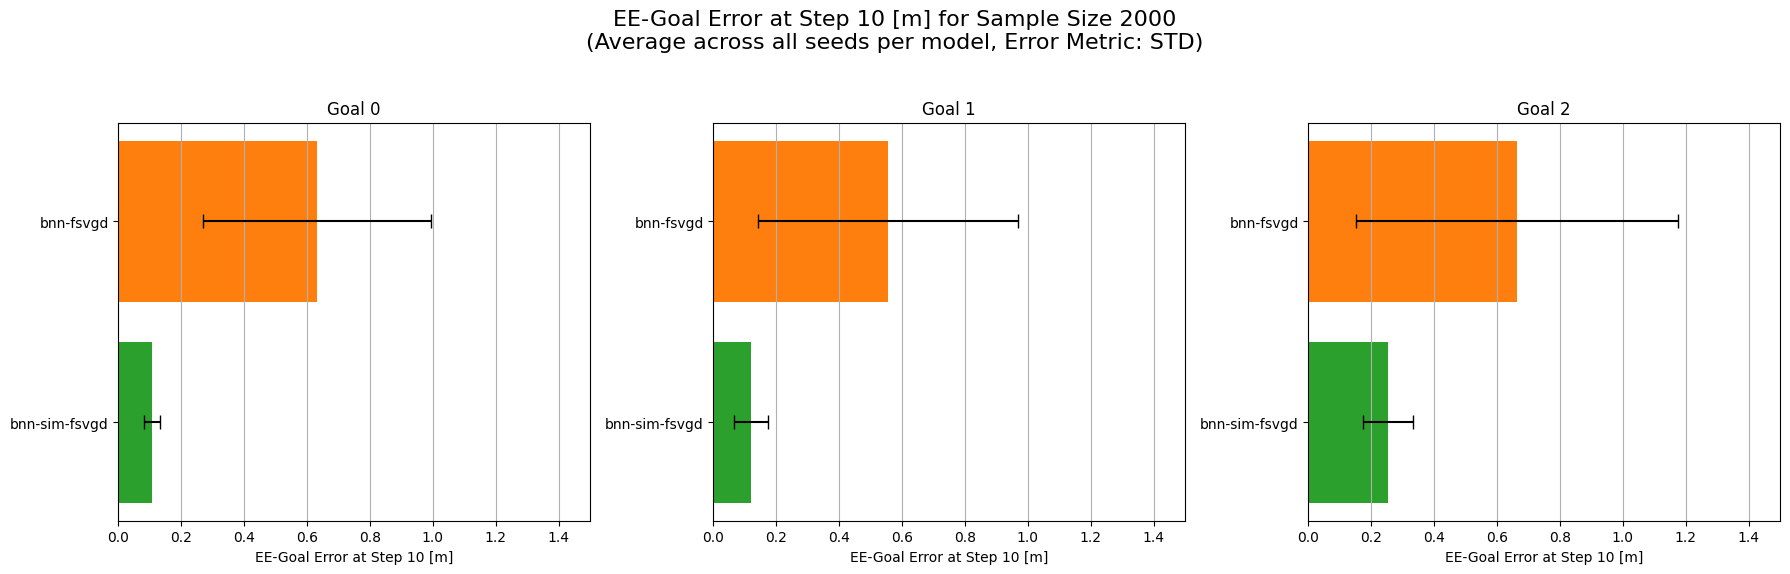

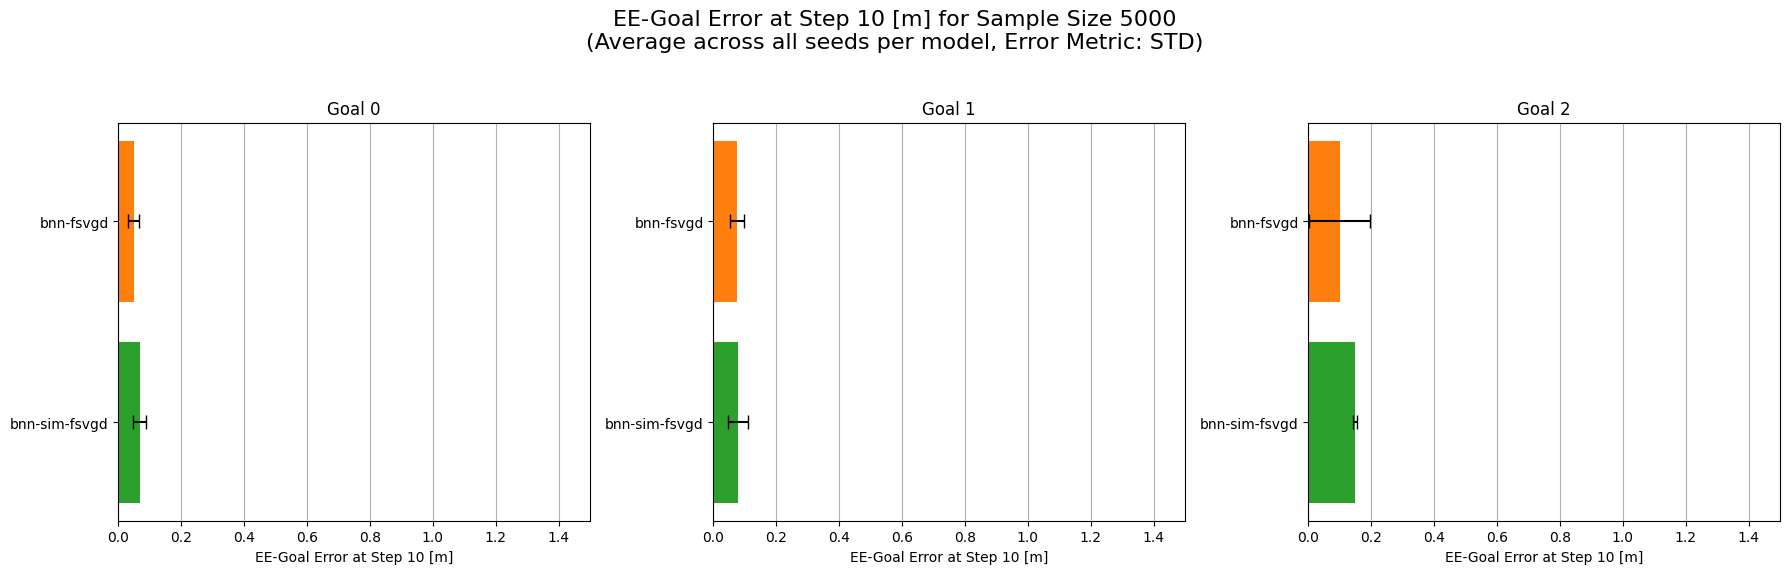

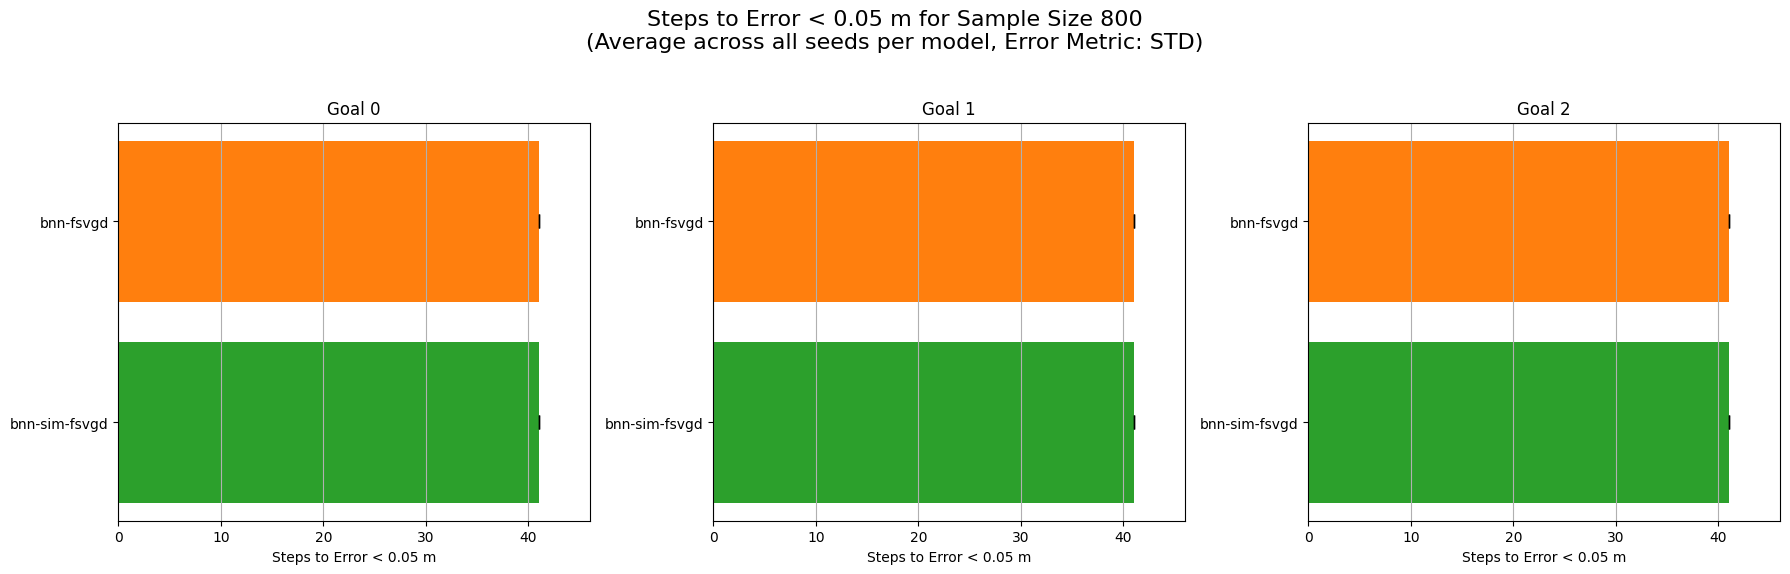

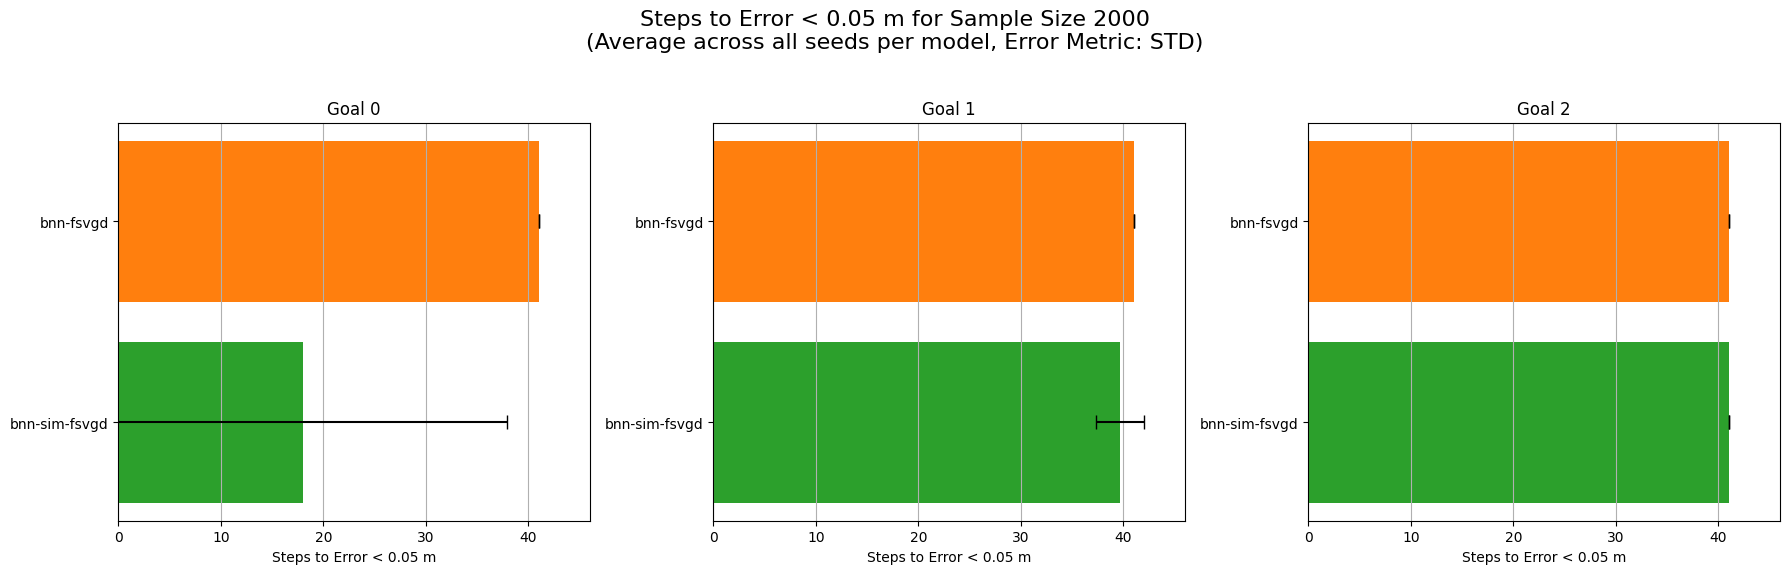

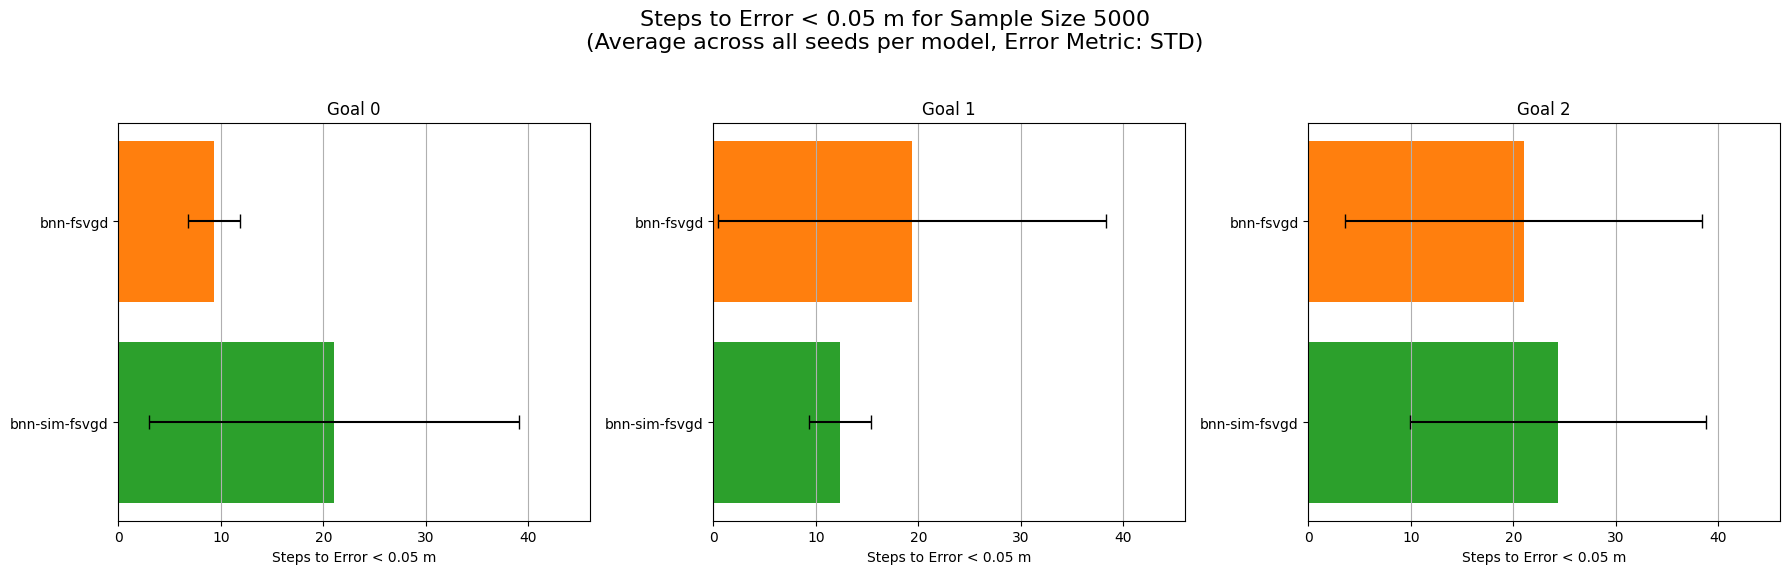

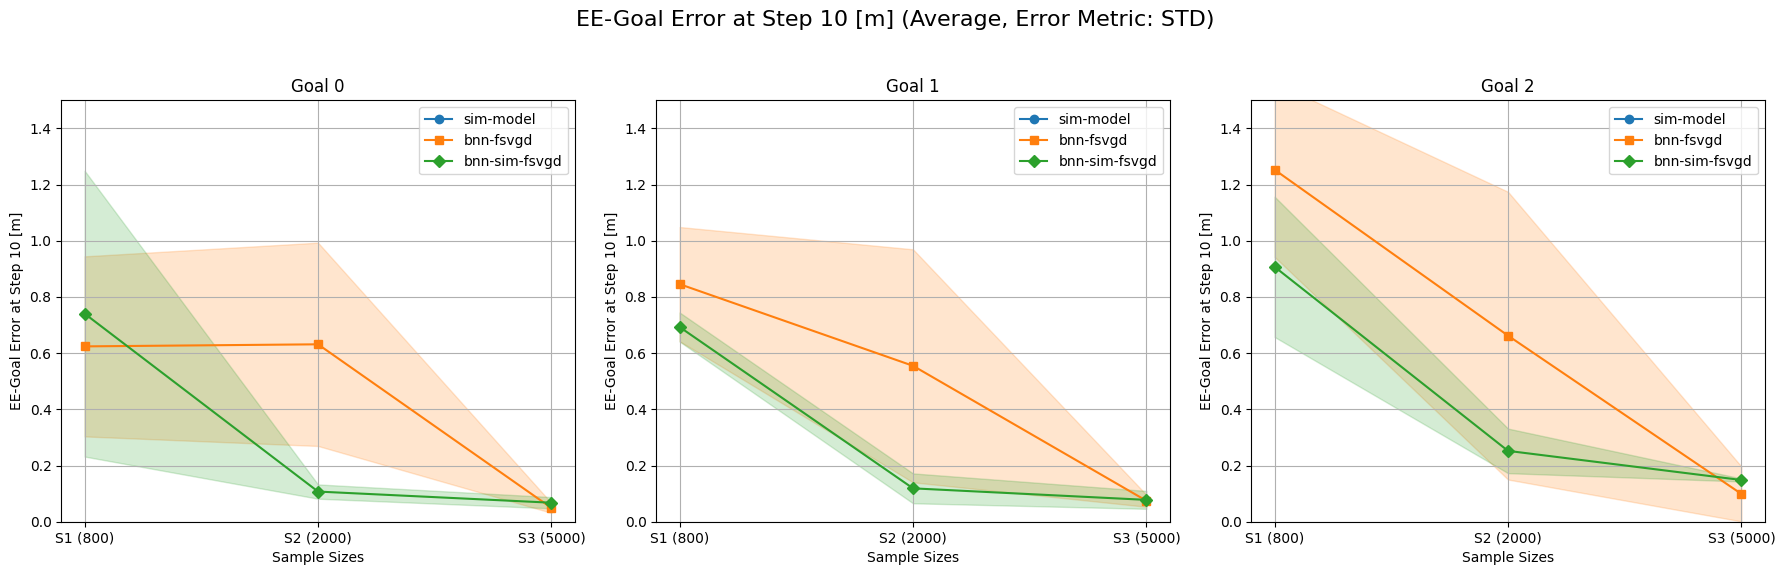

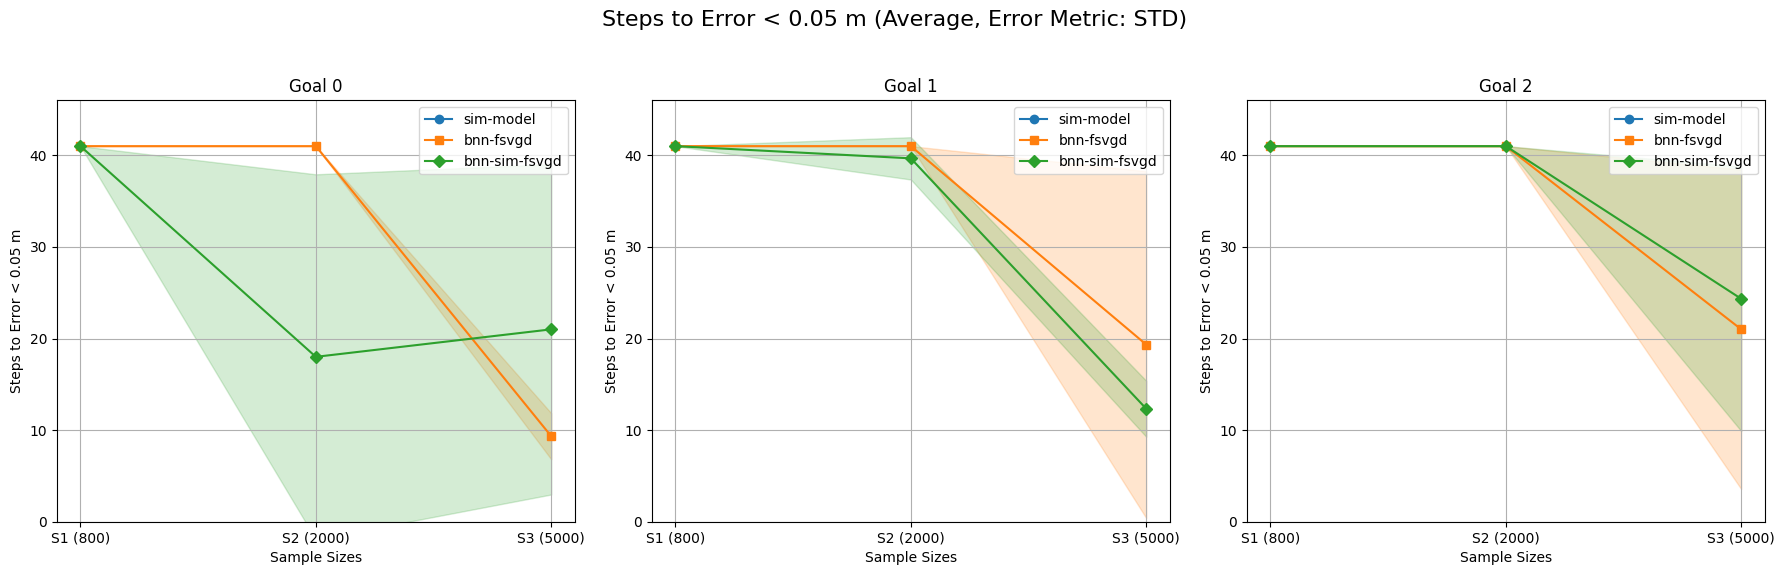

KeyError: 'sim-model'

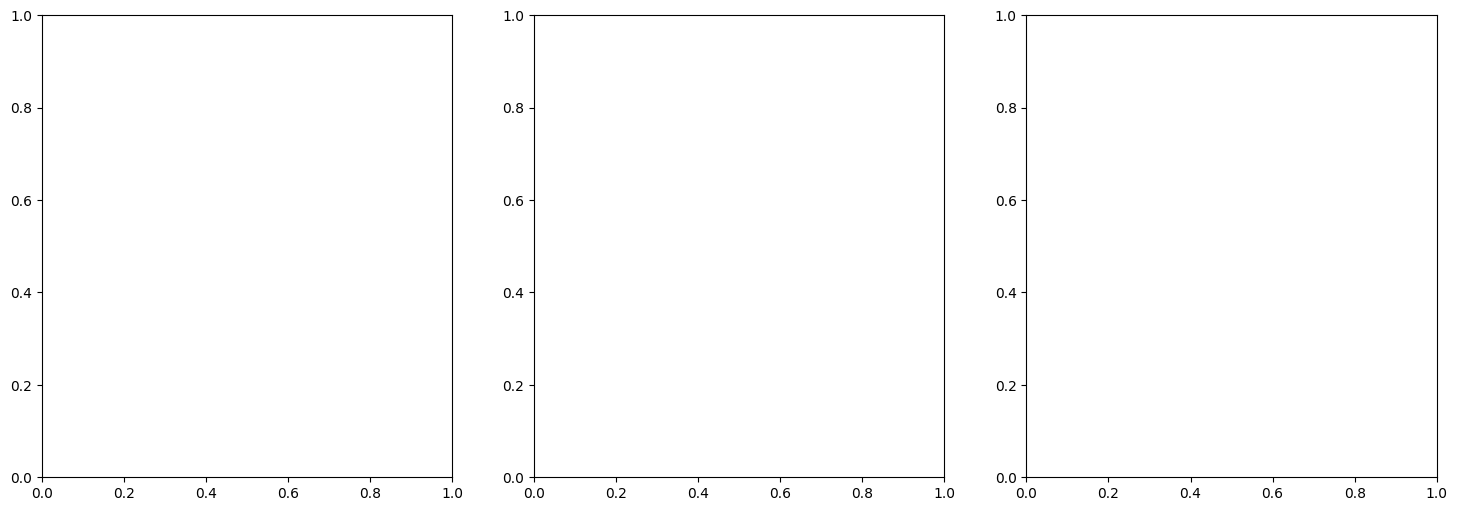

In [4]:
""" Full evaluation of policy performance on real robot """

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sim_transfer.sims.util import decode_angles
from brax.training.types import Transition
import jax.tree_util as jtu
import jax.numpy as jnp
import re
import os
from scipy import stats  # Import stats module for t-distribution critical values
from scipy.ndimage import gaussian_filter1d  # For smoothing

# Use a style for better aesthetics
plt.style.use("seaborn-v0_8-colorblind")

# Global variables
step_index = 10  # Define the step index for error calculation
error_threshold = 0.05  # Threshold for EE-Goal error
plot_analysis = False  # Set to True to enable 'Analysis for Goal x' plots
max_steps = 41
steps_limits = (0, max_steps + 5)  # Set limits for steps axis
error_limits = (0, 1.5)  # Set limits for error axis

plot_variant = 'average'  # Change this to 'best', 'worst', or 'average' as needed

# Define the error metric to use: 'std' for standard deviation, 'ci' for 95% confidence interval, 'min_max' for min/max range
error_metric = 'std'  # Change this to 'std', 'ci' or 'min_max' as needed

# Smoothing factor for EE-goal error over steps plot (set to 0 for no smoothing)
smoothing_sigma = 0  # Adjust this value as needed

# Define the list of trajectory files
file_paths = [
    # policy_testing_full_v9_new
    # bnn_sim_fsvgd
    # seed 1
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-122915_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123002_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123059_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123128_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123214_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123304_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123401_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123441_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123526_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_2__1.0/brax_transitions.pickle",
    # seed 2
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123652_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123736_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123812_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123851_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123942_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124028_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124113_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124157_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124301_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_2__1.0/brax_transitions.pickle",
    # seed 3
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124434_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124513_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124601_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124655_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124742_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124838_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124929_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125016_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125105_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_2__1.0/brax_transitions.pickle",
    
    # # sim_model
    # # seed 1
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125223_policy_testing_full_v9_7539krvw_sim-model_800_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125308_policy_testing_full_v9_7539krvw_sim-model_800_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125348_policy_testing_full_v9_7539krvw_sim-model_800_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125446_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125533_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125617_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125702_policy_testing_full_v9_pnqivxba_sim-model_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125747_policy_testing_full_v9_pnqivxba_sim-model_5000_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125832_policy_testing_full_v9_pnqivxba_sim-model_5000_1_2__1.0/brax_transitions.pickle",
    # # seed 2
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130234_policy_testing_full_v9_dwb45l5k_sim-model_800_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130315_policy_testing_full_v9_dwb45l5k_sim-model_800_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130359_policy_testing_full_v9_dwb45l5k_sim-model_800_2_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130445_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130534_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130616_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130704_policy_testing_full_v9_p50dxhru_sim-model_5000_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130744_policy_testing_full_v9_p50dxhru_sim-model_5000_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130828_policy_testing_full_v9_p50dxhru_sim-model_5000_2_2__1.0/brax_transitions.pickle",
    # # seed 3
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131057_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131139_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131233_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131317_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131411_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131453_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131540_policy_testing_full_v9_fac8woya_sim-model_5000_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131622_policy_testing_full_v9_fac8woya_sim-model_5000_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131709_policy_testing_full_v9_fac8woya_sim-model_5000_3_2__1.0/brax_transitions.pickle",

    # bnn_fsvgd
    # seed 1
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-145848_policy_testing_full_v9_4j9i5pw9_bnn-fsvgd_800_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-150015_policy_testing_full_v9_4j9i5pw9_bnn-fsvgd_800_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-150056_policy_testing_full_v9_4j9i5pw9_bnn-fsvgd_800_1_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-150143_policy_testing_full_v9_05blsrcg_bnn-fsvgd_2000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-150226_policy_testing_full_v9_05blsrcg_bnn-fsvgd_2000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-150311_policy_testing_full_v9_05blsrcg_bnn-fsvgd_2000_1_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-150411_policy_testing_full_v9_tx5ohk4g_bnn-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-150452_policy_testing_full_v9_tx5ohk4g_bnn-fsvgd_5000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-150534_policy_testing_full_v9_tx5ohk4g_bnn-fsvgd_5000_1_2__1.0/brax_transitions.pickle",

    # seed 2
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-150659_policy_testing_full_v9_un61x52u_bnn-fsvgd_800_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-150819_policy_testing_full_v9_un61x52u_bnn-fsvgd_800_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-150859_policy_testing_full_v9_un61x52u_bnn-fsvgd_800_2_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-150938_policy_testing_full_v9_d266heoe_bnn-fsvgd_2000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-151551_policy_testing_full_v9_d266heoe_bnn-fsvgd_2000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-151635_policy_testing_full_v9_d266heoe_bnn-fsvgd_2000_2_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-151716_policy_testing_full_v9_94smmks2_bnn-fsvgd_5000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-151834_policy_testing_full_v9_94smmks2_bnn-fsvgd_5000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-151944_policy_testing_full_v9_94smmks2_bnn-fsvgd_5000_2_2__1.0/brax_transitions.pickle",

    # seed 3
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-152533_policy_testing_full_v9_t1xofuqb_bnn-fsvgd_800_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-152616_policy_testing_full_v9_t1xofuqb_bnn-fsvgd_800_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-152656_policy_testing_full_v9_t1xofuqb_bnn-fsvgd_800_3_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-152741_policy_testing_full_v9_on1h09oj_bnn-fsvgd_2000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-152918_policy_testing_full_v9_on1h09oj_bnn-fsvgd_2000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-152822_policy_testing_full_v9_on1h09oj_bnn-fsvgd_2000_3_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-152958_policy_testing_full_v9_kboo9glz_bnn-fsvgd_5000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-153040_policy_testing_full_v9_kboo9glz_bnn-fsvgd_5000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-153121_policy_testing_full_v9_kboo9glz_bnn-fsvgd_5000_3_2__1.0/brax_transitions.pickle",
]


# Define your goals
goal_1 = np.array([1.2, -0.2, 0.8])
goal_2 = np.array([1.4, 0.2, 0.4])
goal_3 = np.array([1.6, 0.5, 0.2])

goals = [goal_1, goal_2, goal_3]

# Initialize dictionaries to store data per goal and per model type
goal_data = {}
model_data = {}
data_per_model_sample_goal = {}  # Data per model, sample size, and goal

def extract_info_from_file_path(file_path):
    """Extract model info from file path."""
    dir_name = os.path.dirname(file_path)
    dir_base_name = os.path.basename(dir_name)
    parts = dir_base_name.split('_')

    # Find index of 8-character unique id
    for i in range(len(parts)):
        if re.match(r'^\w{8}$', parts[i]):
            uniqueid_parts = parts[:i+1]
            uniqueid = '_'.join(uniqueid_parts)
            rest_parts = parts[i+1:]
            break
    else:
        raise ValueError(f"Could not find unique id in file path {file_path}")

    if len(rest_parts) < 4:
        raise ValueError(f"Not enough parts in file path {file_path}")

    modeltype = rest_parts[0]
    samplesize = rest_parts[1]
    variant = rest_parts[2]
    goalindex = rest_parts[3]

    # Handle the double underscore
    params_and_rest = '_'.join(rest_parts[4:])
    params_split = params_and_rest.split('__')
    if len(params_split) == 2:
        params = params_split[1]
    else:
        # Try splitting by '_'
        params_split = params_and_rest.split('_')
        if len(params_split) >= 1:
            params = params_split[-1]
        else:
            params = ''

    return {
        'uniqueid': uniqueid,
        'modeltype': modeltype,
        'samplesize': samplesize,
        'variant': variant,
        'goalindex': goalindex,
        'params': params
    }

# Loop over each trajectory file
for idx, file_path in enumerate(file_paths):
    # Load trajectory from policy simulation
    with open(file_path, "rb") as file:
        traj_raw = pickle.load(file)

    # Extract info from file path
    info = extract_info_from_file_path(file_path)
    label = f"{info['modeltype']}_{info['samplesize']}_{info['variant']}_g{info['goalindex']}"
    model_type = info['modeltype']
    sample_size = info['samplesize']
    goal_index = int(info['goalindex'])
    variant = info['variant']

    # Extract goal index
    if goal_index >= len(goals):
        raise ValueError(f"Goal index {goal_index} is out of bounds")

    goal = goals[goal_index]

    # Initialize data structures for this goal if not already done
    if goal_index not in goal_data:
        goal_data[goal_index] = {
            "file_paths": [],
            "labels": [],
            "observations": [],
            "actions": [],
            "rewards": [],
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
            "ee_goal_error_over_time": [],  # Add this to store error over time
        }

    # Initialize data structures for this model type if not already done
    if model_type not in model_data:
        model_data[model_type] = {
            "labels": [],
            "observations": [],
            "actions": [],
            "rewards": [],
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
            "goals": [],
            "ee_goal_error_over_time": [],  # Add this to store error over time
        }

    # Initialize data structures for data per model, sample size, and goal
    if model_type not in data_per_model_sample_goal:
        data_per_model_sample_goal[model_type] = {}
    if sample_size not in data_per_model_sample_goal[model_type]:
        data_per_model_sample_goal[model_type][sample_size] = {}
    if goal_index not in data_per_model_sample_goal[model_type][sample_size]:
        data_per_model_sample_goal[model_type][sample_size][goal_index] = {
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
            "labels": [],
            "observations": [],  # Store observations for trajectory plotting
            "variants": [],  # Store variants
            "ee_goal_error_over_time": [],  # Store error over time
        }

    # Add goal to observations
    def add_goal_to_obs(obs: jnp.ndarray, goal: jnp.ndarray) -> jnp.ndarray:
        return jnp.concatenate([obs, goal])

    new_traj = []

    # Add goal to each observation in the trajectory
    for i in range(len(traj_raw)):
        obs = traj_raw[i].observation
        next_obs = traj_raw[i].next_observation
        obs = add_goal_to_obs(obs, goal)
        next_obs = add_goal_to_obs(next_obs, goal)
        new_traj.append(
            Transition(
                observation=obs,
                action=traj_raw[i].action,
                reward=jnp.array(0),
                next_observation=next_obs,
                discount=traj_raw[i].discount,
            )
        )

    traj = jtu.tree_map(lambda *xs: jnp.stack(xs, axis=0), *new_traj)

    # Convert transitions to trajectory
    observations = traj.observation
    actions = traj.action
    rewards = traj.reward

    # Decode angles if needed
    if observations.shape[-1] == 16:
        observations = decode_angles(observations, 2)

    # Convert observations to numpy array
    observations_np = np.array(observations)

    # Calculate EE-Goal error over time
    ee_pos = observations_np[:, 6:9]
    goal_pos = observations_np[:, -3:]
    error = np.linalg.norm(ee_pos - goal_pos, axis=1)

    # if error is shorter than max_steps, repeat the last value until max_steps
    if len(error) < max_steps:
        error = np.pad(error, (0, max_steps - len(error)), mode='edge')

    # EE-Goal error at step_index
    if len(error) > step_index:
        ee_goal_error_at_step = error[step_index]
    else:
        ee_goal_error_at_step = np.nan

    # Steps until error drops below threshold
    steps_below_threshold = np.where(error < error_threshold)[0]
    if steps_below_threshold.size > 0:
        steps_to_threshold = steps_below_threshold[0]
    else:
        # steps_to_threshold = np.nan  # Did not reach threshold
        steps_to_threshold = len(error)  # Set to max steps

    # Append data to the corresponding goal
    goal_data[goal_index]["file_paths"].append(file_path)
    goal_data[goal_index]["labels"].append(label)
    goal_data[goal_index]["observations"].append(observations_np)
    goal_data[goal_index]["actions"].append(np.array(actions))
    goal_data[goal_index]["rewards"].append(np.array(rewards))
    goal_data[goal_index]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    goal_data[goal_index]["steps_below_threshold"].append(steps_to_threshold)
    goal_data[goal_index]["ee_goal_error_over_time"].append(error)

    # Append data to the corresponding model type
    model_data[model_type]["labels"].append(f"{label}")
    model_data[model_type]["observations"].append(observations_np)
    model_data[model_type]["actions"].append(np.array(actions))
    model_data[model_type]["rewards"].append(np.array(rewards))
    model_data[model_type]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    model_data[model_type]["steps_below_threshold"].append(steps_to_threshold)
    model_data[model_type]["goals"].append(goal_index)
    model_data[model_type]["ee_goal_error_over_time"].append(error)

    # Append data to data_per_model_sample_goal
    data_per_model_sample_goal[model_type][sample_size][goal_index]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    data_per_model_sample_goal[model_type][sample_size][goal_index]["steps_below_threshold"].append(steps_to_threshold)
    data_per_model_sample_goal[model_type][sample_size][goal_index]["labels"].append(label)
    data_per_model_sample_goal[model_type][sample_size][goal_index]["observations"].append(observations_np)  # Store observations
    data_per_model_sample_goal[model_type][sample_size][goal_index]["variants"].append(variant)
    data_per_model_sample_goal[model_type][sample_size][goal_index]["ee_goal_error_over_time"].append(error)

# Ensure the model types are in the specified order
model_types = ["sim-model", "bnn-fsvgd", "bnn-sim-fsvgd"]

# Extract sample sizes
sample_sizes = set()
for model_type in data_per_model_sample_goal:
    for sample_size in data_per_model_sample_goal[model_type]:
        sample_sizes.add(sample_size)

sample_sizes = sorted(sample_sizes, key=lambda x: int(x))  # Sort numerically

# Define colors for consistency
colors = plt.get_cmap('tab10').colors
color_dict = dict(zip(model_types, colors))

# Function to compute statistics based on plot_variant and error_metric
def compute_statistics(data_per_model_sample_goal, plot_variant, error_metric):
    """Compute statistics based on the selected plot_variant and error_metric."""
    stats_ee_goal_error_at_step = {}
    stats_steps_below_threshold = {}
    stats_ee_goal_error_over_time = {}
    selected_trajectories = {}

    for model_type in data_per_model_sample_goal:
        stats_ee_goal_error_at_step[model_type] = {}
        stats_steps_below_threshold[model_type] = {}
        stats_ee_goal_error_over_time[model_type] = {}
        selected_trajectories[model_type] = {}
        for sample_size in data_per_model_sample_goal[model_type]:
            stats_ee_goal_error_at_step[model_type][sample_size] = {}
            stats_steps_below_threshold[model_type][sample_size] = {}
            stats_ee_goal_error_over_time[model_type][sample_size] = {}
            selected_trajectories[model_type][sample_size] = {}
            for goal_index in data_per_model_sample_goal[model_type][sample_size]:
                errors = data_per_model_sample_goal[model_type][sample_size][goal_index]['ee_goal_errors_at_step']
                steps = data_per_model_sample_goal[model_type][sample_size][goal_index]['steps_below_threshold']
                labels = data_per_model_sample_goal[model_type][sample_size][goal_index]['labels']
                observations_list = data_per_model_sample_goal[model_type][sample_size][goal_index]['observations']
                variants = data_per_model_sample_goal[model_type][sample_size][goal_index]['variants']
                errors_over_time_list = data_per_model_sample_goal[model_type][sample_size][goal_index]['ee_goal_error_over_time']

                # Remove NaN values before computing statistics
                valid_indices = [i for i in range(len(errors)) if not np.isnan(errors[i]) or not np.isnan(steps[i])]

                # Compute average and error metric (std, ci, or min_max)
                errors_clean = [errors[i] for i in valid_indices if not np.isnan(errors[i])]
                steps_clean = [steps[i] for i in valid_indices if not np.isnan(steps[i])]
                errors_over_time_clean = [errors_over_time_list[i] for i in valid_indices]

                n_errors = len(errors_clean)
                n_steps = len(steps_clean)
                n_time = len(errors_over_time_clean)

                # Initialize arrays for errors over time
                max_length = max([len(e) for e in errors_over_time_clean]) if errors_over_time_clean else 0
                errors_over_time_array = np.full((n_time, max_length), np.nan)

                for idx, e in enumerate(errors_over_time_clean):
                    errors_over_time_array[idx, :len(e)] = e

                if errors_clean:
                    avg_error = np.mean(errors_clean)
                    if error_metric == 'std':
                        error_error = np.std(errors_clean, ddof=1)
                    elif error_metric == 'ci':
                        std_error = np.std(errors_clean, ddof=1)
                        se_error = std_error / np.sqrt(n_errors)
                        t_crit = stats.t.ppf(0.975, df=n_errors - 1)
                        error_error = se_error * t_crit
                    elif error_metric == 'min_max':
                        min_error = np.min(errors_clean)
                        max_error = np.max(errors_clean)
                        error_error = (min_error, max_error)
                    else:
                        raise ValueError("Invalid error_metric. Use 'std', 'ci', or 'min_max'.")
                else:
                    avg_error = error_error = np.nan

                if steps_clean:
                    avg_step = np.mean(steps_clean)
                    if error_metric == 'std':
                        error_step = np.std(steps_clean, ddof=1)
                    elif error_metric == 'ci':
                        std_step = np.std(steps_clean, ddof=1)
                        se_step = std_step / np.sqrt(n_steps)
                        t_crit = stats.t.ppf(0.975, df=n_steps - 1)
                        error_step = se_step * t_crit
                    elif error_metric == 'min_max':
                        min_step = np.min(steps_clean)
                        max_step = np.max(steps_clean)
                        error_step = (min_step, max_step)
                    else:
                        raise ValueError("Invalid error_metric. Use 'std', 'ci', or 'min_max'.")
                else:
                    avg_step = error_step = np.nan

                # Compute statistics over time
                if errors_over_time_clean:
                    avg_error_over_time = np.nanmean(errors_over_time_array, axis=0)
                    if error_metric == 'std':
                        error_over_time = np.nanstd(errors_over_time_array, axis=0, ddof=1)
                    elif error_metric == 'ci':
                        std_over_time = np.nanstd(errors_over_time_array, axis=0, ddof=1)
                        se_over_time = std_over_time / np.sqrt(n_time)
                        t_crit = stats.t.ppf(0.975, df=n_time - 1)
                        error_over_time = se_over_time * t_crit
                    elif error_metric == 'min_max':
                        min_over_time = np.nanmin(errors_over_time_array, axis=0)
                        print(min_over_time)
                        max_over_time = np.nanmax(errors_over_time_array, axis=0)
                        print(max_over_time)
                        error_over_time = (min_over_time, max_over_time)
                    else:
                        raise ValueError("Invalid error_metric. Use 'std', 'ci', or 'min_max'.")
                else:
                    avg_error_over_time = error_over_time = np.nan

                stats_ee_goal_error_at_step[model_type][sample_size][goal_index] = (avg_error, error_error)
                stats_steps_below_threshold[model_type][sample_size][goal_index] = (avg_step, error_step)
                stats_ee_goal_error_over_time[model_type][sample_size][goal_index] = (avg_error_over_time, error_over_time)

                # Select trajectory for plotting
                if valid_indices:
                    # Prepare lists for available errors and steps
                    error_indices = [i for i in valid_indices if not np.isnan(errors[i])]
                    error_values_array = np.array([errors[i] for i in error_indices])
                    error_ranks = error_values_array.argsort().argsort()
                    error_ranks_dict = dict(zip(error_indices, error_ranks))

                    step_indices = [i for i in valid_indices if not np.isnan(steps[i])]
                    step_values_array = np.array([steps[i] for i in step_indices])
                    step_ranks = step_values_array.argsort().argsort()
                    step_ranks_dict = dict(zip(step_indices, step_ranks))

                    # Compute total ranks
                    total_ranks = {}
                    for idx in valid_indices:
                        ranks = 0
                        if idx in error_ranks_dict and idx in step_ranks_dict:
                            # Both indicators available
                            ranks = error_ranks_dict[idx] + step_ranks_dict[idx]
                        elif idx in error_ranks_dict:
                            # Only error available
                            ranks = 2 * error_ranks_dict[idx]
                        elif idx in step_ranks_dict:
                            # Only step available
                            ranks = 2 * step_ranks_dict[idx]
                        else:
                            continue  # Should not happen
                        total_ranks[idx] = ranks

                    if plot_variant == 'best':
                        selected_idx = min(total_ranks, key=total_ranks.get)
                    elif plot_variant == 'worst':
                        selected_idx = max(total_ranks, key=total_ranks.get)
                    elif plot_variant == 'average':
                        # Select median rank
                        sorted_total_ranks = sorted(total_ranks.items(), key=lambda x: x[1])
                        median_idx = len(sorted_total_ranks) // 2
                        selected_idx = sorted_total_ranks[median_idx][0]

                    selected_error = errors[selected_idx]
                    selected_step = steps[selected_idx]
                    selected_label = labels[selected_idx]
                    selected_observation = observations_list[selected_idx]
                    selected_variant = variants[selected_idx]
                    selected_error_over_time = errors_over_time_list[selected_idx]

                    selected_trajectories[model_type][sample_size][goal_index] = {
                        'label': selected_label,
                        'observations': selected_observation,
                        'variant': selected_variant,
                        'error_over_time': selected_error_over_time,
                    }

                else:
                    # No valid data
                    selected_trajectories[model_type][sample_size][goal_index] = None

    return stats_ee_goal_error_at_step, stats_steps_below_threshold, stats_ee_goal_error_over_time, selected_trajectories

# Compute statistics based on the selected plot_variant and error_metric
(stats_ee_goal_error_at_step,
 stats_steps_below_threshold,
 stats_ee_goal_error_over_time,
 selected_trajectories) = compute_statistics(
    data_per_model_sample_goal, plot_variant, error_metric
)

# Plotting functions

def plot_per_sample_size_horizontal_bar(stats_data, sample_sizes, model_types, metric_name, x_limits=None, error_metric='std'):
    """Plot horizontal bar charts per sample size per goal."""
    for sample_size in sample_sizes:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        for goal_index in range(3):  # Assuming goals are 0,1,2
            ax = axs[goal_index]
            avg_values = []
            error_values = []
            labels = []
            colors = []
            for idx, model_type in enumerate(model_types):
                if sample_size in stats_data.get(model_type, {}):
                    if goal_index in stats_data[model_type][sample_size]:
                        avg_value, error_value = stats_data[model_type][sample_size][goal_index]
                        avg_values.append(avg_value)
                        if error_metric == 'min_max':
                            min_value, max_value = error_value
                            error_values.append([[min_value], [max_value]])
                        else:
                            error_values.append(error_value)
                        labels.append(model_type)
                        colors.append(color_dict[model_type])
            y_positions = np.arange(len(labels))
            # Convert lists to NumPy arrays
            avg_values = np.array(avg_values)
            if error_metric == 'min_max':
                # Convert error_values to arrays of lower and upper errors
                lower_errors = [e[0][0] for e in error_values]
                upper_errors = [e[1][0] for e in error_values]
                asymmetric_error = [lower_errors, upper_errors]
                ax.barh(y_positions, avg_values, xerr=asymmetric_error, align='center', color=colors, ecolor='black', capsize=5)
            elif plot_variant == 'average':
                error_values = np.array(error_values)
                # Plot bars with error bars representing std or ci
                ax.barh(y_positions, avg_values, xerr=error_values, align='center', color=colors, ecolor='black', capsize=5)
            else:
                # Plot bars without error bars
                ax.barh(y_positions, avg_values, align='center', color=colors)
            ax.set_yticks(y_positions)
            ax.set_yticklabels(labels)
            ax.set_xlabel(metric_name)
            ax.set_title(f"Goal {goal_index}")
            ax.invert_yaxis()
            ax.grid(True, axis='x')
            if x_limits is not None:
                ax.set_xlim(x_limits)
        plt.suptitle(f"{metric_name} for Sample Size {sample_size}\n({plot_variant.capitalize()} across all seeds per model, Error Metric: {error_metric.upper()})", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

def plot_metric_vs_sample_size_line(stats_data, sample_sizes, model_types, metric_name, y_limits=None, error_metric='std'):
    """Plot line charts per plot type with one subplot per goal."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for goal_index in range(3):  # Assuming goals are 0,1,2
        ax = axs[goal_index]
        markers = ['o', 's', 'D', '^', 'v']  # Extend markers if needed
        for idx, model_type in enumerate(model_types):
            avg_values = []
            error_values = []
            sample_size_labels = []
            for sample_size in sample_sizes:
                sample_size_labels.append(f"S{sample_sizes.index(sample_size)+1} ({sample_size})")
                if sample_size in stats_data.get(model_type, {}):
                    if goal_index in stats_data[model_type][sample_size]:
                        avg_value, error_value = stats_data[model_type][sample_size][goal_index]
                        avg_values.append(avg_value)
                        if error_metric == 'min_max':
                            min_value, max_value = error_value
                            error_values.append((min_value, max_value))
                        else:
                            error_values.append(error_value)
                    else:
                        avg_values.append(np.nan)
                        error_values.append(0)
                else:
                    avg_values.append(np.nan)
                    error_values.append(0)
            # Convert lists to NumPy arrays
            avg_values = np.array(avg_values)
            x_positions = np.arange(len(sample_sizes))
            # Plot line
            if plot_variant == 'average':
                # Plot with shaded area or error bars
                ax.plot(x_positions, avg_values, label=f"{model_type}", color=color_dict[model_type], marker=markers[idx % len(markers)])
                if error_metric == 'min_max':
                    lower_errors = np.array([e[0] for e in error_values])
                    upper_errors = np.array([e[1] for e in error_values])
                    ax.fill_between(x_positions, lower_errors, upper_errors, color=color_dict[model_type], alpha=0.2)
                else:
                    error_values = np.array(error_values)
                    ax.fill_between(x_positions, avg_values - error_values, avg_values + error_values, color=color_dict[model_type], alpha=0.2)
            else:
                # Plot without error bars
                ax.plot(x_positions, avg_values, label=f"{model_type}", color=color_dict[model_type], marker=markers[idx % len(markers)])
        # Set x-axis labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels([f"S{sample_sizes.index(s)+1} ({s})" for s in sample_sizes])
        ax.set_xlabel("Sample Sizes")
        ax.set_ylabel(metric_name)
        ax.set_title(f"Goal {goal_index}")
        ax.legend(loc='upper right')
        ax.grid(True)
        if y_limits is not None:
            ax.set_ylim(y_limits)
    plt.suptitle(f"{metric_name} ({plot_variant.capitalize()}, Error Metric: {error_metric.upper()})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_best_2d_trajectories(selected_trajectories, x_limits, y_limits):
    """Plot the best/worst/median 2D trajectories per sample size and goal."""
    for sample_size in sample_sizes:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        for goal_index in range(3):
            ax = axs[goal_index]
            for model_type in model_types:
                traj_info = selected_trajectories[model_type][sample_size].get(goal_index)
                if traj_info and traj_info['observations'] is not None:
                    obs = traj_info['observations']
                    label = traj_info['label']
                    # Extract variant from label
                    variant = traj_info['variant']
                    label_with_variant = f"{model_type} {variant}"
                    color = color_dict[model_type]
                    # Plot EE trajectory
                    ax.plot(obs[:, 6], obs[:, 7], label=label_with_variant, color=color)
                    # Plot EE start and end points
                    ax.plot(obs[0, 6], obs[0, 7], "o", color=color, markersize=8)
                    ax.plot(obs[-1, 6], obs[-1, 7], "s", color=color, markersize=8)
                    # Plot goal position
                    ax.plot(obs[0, -3], obs[0, -2], "x", color="black", markersize=10)
            ax.set_title(f"Goal {goal_index}")
            ax.set_xlabel("X [m]")
            ax.set_ylabel("Y [m]")
            ax.axis("equal")
            ax.set_xlim(x_limits)
            ax.set_ylim(y_limits)
            ax.legend()
            ax.grid(True)
        plt.suptitle(f"{plot_variant.capitalize()} 2D Trajectories for Sample Size {sample_size}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

def plot_ee_goal_error_over_steps(stats_ee_goal_error_over_time, sample_sizes, model_types, smoothing_sigma=0, error_limits=None):
    """Plot EE-Goal error over steps per sample size and goal."""
    for sample_size in sample_sizes:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        for goal_index in range(3):
            ax = axs[goal_index]
            for idx, model_type in enumerate(model_types):
                if sample_size in stats_ee_goal_error_over_time.get(model_type, {}):
                    if goal_index in stats_ee_goal_error_over_time[model_type][sample_size]:
                        avg_error_over_time, error_over_time = stats_ee_goal_error_over_time[model_type][sample_size][goal_index]
                        if avg_error_over_time is not None:
                            steps = np.arange(len(avg_error_over_time))
                            color = color_dict[model_type]
                            label = model_type
                            if smoothing_sigma > 0:
                                avg_error_over_time = gaussian_filter1d(avg_error_over_time, sigma=smoothing_sigma)
                                if error_metric == 'min_max' and isinstance(error_over_time, tuple):
                                    error_over_time = (gaussian_filter1d(error_over_time[0], sigma=smoothing_sigma),
                                                       gaussian_filter1d(error_over_time[1], sigma=smoothing_sigma))
                                elif isinstance(error_over_time, np.ndarray):
                                    error_over_time = gaussian_filter1d(error_over_time, sigma=smoothing_sigma)
                            ax.plot(steps, avg_error_over_time, label=label, color=color)
                            if plot_variant == 'average':
                                if error_metric == 'min_max' and isinstance(error_over_time, tuple):
                                    # lower_bound = avg_error_over_time - error_over_time[0]
                                    # upper_bound = avg_error_over_time + error_over_time[1]
                                    lower_bound = error_over_time[0]
                                    upper_bound = error_over_time[1]
                                    ax.fill_between(steps, lower_bound, upper_bound, color=color, alpha=0.2)
                                else:
                                    lower_bound = avg_error_over_time - error_over_time
                                    upper_bound = avg_error_over_time + error_over_time
                                    ax.fill_between(steps, lower_bound, upper_bound, color=color, alpha=0.2)
            ax.set_title(f"Goal {goal_index}")
            ax.set_xlabel("Steps")
            ax.set_ylabel("EE-Goal Error [m]")
            ax.grid(True)
            if error_limits is not None:
                ax.set_ylim(error_limits)
            ax.legend()
            # Add vertical dotted line at step_index
            ax.axvline(x=step_index, color='red', linestyle='--')
        plt.suptitle(f"EE-Goal Error over Steps for Sample Size {sample_size} ({plot_variant.capitalize()}, Error Metric: {error_metric.upper()})", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Plotting per your specifications

# 0. Plot EE-Goal Error over Steps per sample size and goal
plot_ee_goal_error_over_steps(stats_ee_goal_error_over_time, sample_sizes, model_types, smoothing_sigma=smoothing_sigma, error_limits=error_limits)

# 1. Per sample size, horizontal bar charts with subplots per goal

# Plot EE-Goal Error at Step 10
plot_per_sample_size_horizontal_bar(stats_ee_goal_error_at_step, sample_sizes, model_types, f"EE-Goal Error at Step {step_index} [m]", x_limits=error_limits, error_metric=error_metric)

# Plot Steps to Error < threshold
plot_per_sample_size_horizontal_bar(stats_steps_below_threshold, sample_sizes, model_types, f"Steps to Error < {error_threshold} m", x_limits=steps_limits, error_metric=error_metric)

# 2. Line plots grouped into one figure per plot type with subplots per goal, legend in top right

# Plot EE-Goal Error at Step 10 vs. Sample Sizes
plot_metric_vs_sample_size_line(stats_ee_goal_error_at_step, sample_sizes, model_types, f"EE-Goal Error at Step {step_index} [m]", y_limits=error_limits, error_metric=error_metric)

# Plot Steps to Error < threshold vs. Sample Sizes
plot_metric_vs_sample_size_line(stats_steps_below_threshold, sample_sizes, model_types, f"Steps to Error < {error_threshold} m", y_limits=steps_limits, error_metric=error_metric)

# 3. Plot best/worst/median 2D trajectories per sample size and goal if plot_variant is 'best', 'worst', or 'average'

if plot_variant in ['best', 'worst', 'average']:
    # Define x and y limits for the plots
    x_limits = (0.2, 2.0)
    y_limits = (-1.5, 1.5)
    # Plot best/worst/median 2D trajectories
    plot_best_2d_trajectories(selected_trajectories, x_limits, y_limits)